## Principal component analysis on firing rates



#### 0 Load data

> Choose a session to work with.

#### 1 Preprocess

> Perform the required preprocessing steps and convert spike trains to firing rates.

#### 2 Dimensionality reduction

> Perform PCA on the firing rates.

#### 3 Analyse the PC weights

> Make distributions of the weight different for different categories.

#### 4 Compare self and global manifold

> Find out if the self and global manifold are correlated

---

In [1]:
'''
Dependencies
'''
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sparse
import warnings 
from scipy import integrate
import seaborn as sns
warnings.simplefilter('ignore')
from sklearn import metrics
from sklearn import decomposition
from sklearn.preprocessing import normalize
from scipy.stats import ks_2samp
import scipy.io as sio
import os
import importlib
import rutils
from pyaldata import *
from rutils import *
from tqdm import tqdm

'''
Plotting aesthetics
'''
sns.set_style('white')
sns.set_context('notebook', font_scale=1.35)

#sns.light_palette(color='electric blue', input='xkcd')
cmap = sns.light_palette(color='electric blue', input='xkcd', as_cmap=True)
div_cmap = sns.diverging_palette(250, 150, as_cmap=True)

cs = ['#319FF1', '#0B3856', '#C32D13', '#EBE12E', '#3D7E43', '#2D2F39', '#4D7399', '#CDBCA5']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cs)

'''
Magic commands
'''
%load_ext autoreload
%autoreload 5
%config InlineBackend.figure_format = 'retina'

[xkcd colors](https://xkcd.com/color/rgb/)

## 0 Load data

In [2]:
'''
Insert path and filename 
'''
path = '/Users/Daphne/Data/'  

fname = 'Chewie_CO_FF_2016-10-07.mat'  # file matt used to generate results

#fname = 'Chewie_CO_VR_2016-10-06.mat' # file I originally used

#fname = 'Chewie_CO_FF_2016-10-07.mat' # file matt used after -> results aren't quite clear

df = mat2dataframe(path+fname, shift_idx_fields=True)

In [3]:
df.shape

(662, 24)

In [4]:
df.head()

,monkey,date,task,target_direction,trial_id,result,bin_size,perturbation,perturbation_info,epoch,...,idx_peak_speed,idx_trial_end,pos,vel,acc,force,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide
0,Chewie,10-07-2016,CO,0.785398,1,R,0.01,FF,"[0.15, -1.48]",BL,...,283,348,"[[5.007176198334552, -34.99360130711506], [4.9...","[[-3.8194303264228644, 5.053244196485092], [-4...","[[-31.059549930696612, 60.20927639208206], [-3...","[[0.1734627907455606, 0.3359947817408081], [0....","[[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [3, 1], [4, 1], [5, 1], [9, 1], [10, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [4, 1], [4, 2], [7, 1], [7, 2], [7, 3..."
1,Chewie,10-07-2016,CO,1.570796,2,I,0.01,FF,"[0.15, -1.48]",BL,...,361,380,"[[5.958710402552992, -24.617908380176214], [5....","[[-1.3530730575338556, -3.7182578050768536], [...","[[-15.200457122934276, 0.587247962826], [-11.6...","[[0.3169067039686837, 0.08302175748016484], [0...","[[0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,...","[[1, 1], [3, 1], [4, 1], [5, 1], [9, 1], [10, ...","[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [4, 1], [4, 2], [7, 1], [7, 2], [7, 3..."
2,Chewie,10-07-2016,CO,2.356194,4,R,0.01,FF,"[0.15, -1.48]",BL,...,403,490,"[[0.5627793283057443, -29.234033934273153], [0...","[[-6.484828811760141, 5.6969773438044475], [-6...","[[26.907925985727758, 69.47467715514068], [41....","[[0.18083042966828936, 0.17961238629031656], [...","[[0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 1, 0,...","[[1, 1], [3, 1], [4, 1], [5, 1], [9, 1], [10, ...","[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [4, 1], [4, 2], [7, 1], [7, 2], [7, 3..."
3,Chewie,10-07-2016,CO,3.141593,5,R,0.01,FF,"[0.15, -1.48]",BL,...,291,367,"[[-5.857443240372017, -24.44485683025777], [-5...","[[0.7739062930506245, -2.8991941114535797], [1...","[[34.23054488471853, 22.26419433795642], [44.5...","[[0.5834451069449638, -0.11127098328046767], [...","[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [3, 1], [4, 1], [5, 1], [9, 1], [10, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [4, 1], [4, 2], [7, 1], [7, 2], [7, 3..."
4,Chewie,10-07-2016,CO,0.000000,6,R,0.01,FF,"[0.15, -1.48]",BL,...,287,358,"[[-7.703141633558577, -29.990167782939956], [-...","[[5.840333985636672, 0.03568825072211089], [6....","[[32.01438071308044, 20.64139408470477], [41.5...","[[0.6348732505744654, -0.11377458655096101], [...","[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...","[[1, 1], [3, 1], [4, 1], [5, 1], [9, 1], [10, ...","[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [4, 1], [4, 2], [7, 1], [7, 2], [7, 3..."


## 1 Preprocess 

### 1.1 Combine time bins

In [5]:
td = combine_time_bins(df, n_bins=3)

### 1.2 Remove low firing neurons

In [6]:
td = remove_low_firing_neurons(td, signal='M1_spikes', threshold=5)
td = remove_low_firing_neurons(td, signal='PMd_spikes', threshold=5)

### 1.3 Transform signals

In [7]:
td = transform_signal(td, signal='M1_spikes',  transformations='sqrt')
td = transform_signal(td, signal='PMd_spikes', transformations='sqrt')

### 1.4 Merge signals

In [8]:
td = merge_signals(td, ['M1_spikes', 'PMd_spikes'], 'both_spikes')

In [9]:
td['M1_spikes'][0].shape # timepoints x M1 neurons

(119, 47)

In [10]:
td['both_spikes'][0].shape # timepoints x PMd neurons

(119, 130)

### 1.5 Compute firing rates from spike trains

Add firing rates for `M1_spikes`, `PMd_spikes` and `both_spikes`

In [11]:
# works on '_spikes' fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth')

### 1.6 Select data from Baseline epoch

Select only those rows from the baseline epoch `'BL'`

In [12]:
td = td.loc[df['epoch'] == 'BL']

In [13]:
td.shape

(182, 28)

### 1.7 Keep only succesful trials

In [14]:
print(f'all trials: {td.shape[0]}')

td = select_trials(td, "result == 'R'")

print(f'successful trials: {td.shape[0]}')

all trials: 182
successful trials: 170


## 2 Dimensionality reduction

### 2.1 Do PCA on both arrays

`both_rates`

In [16]:
m1pmd_pcs, m1pmd_var = getPCA(rates=td['both_rates'])

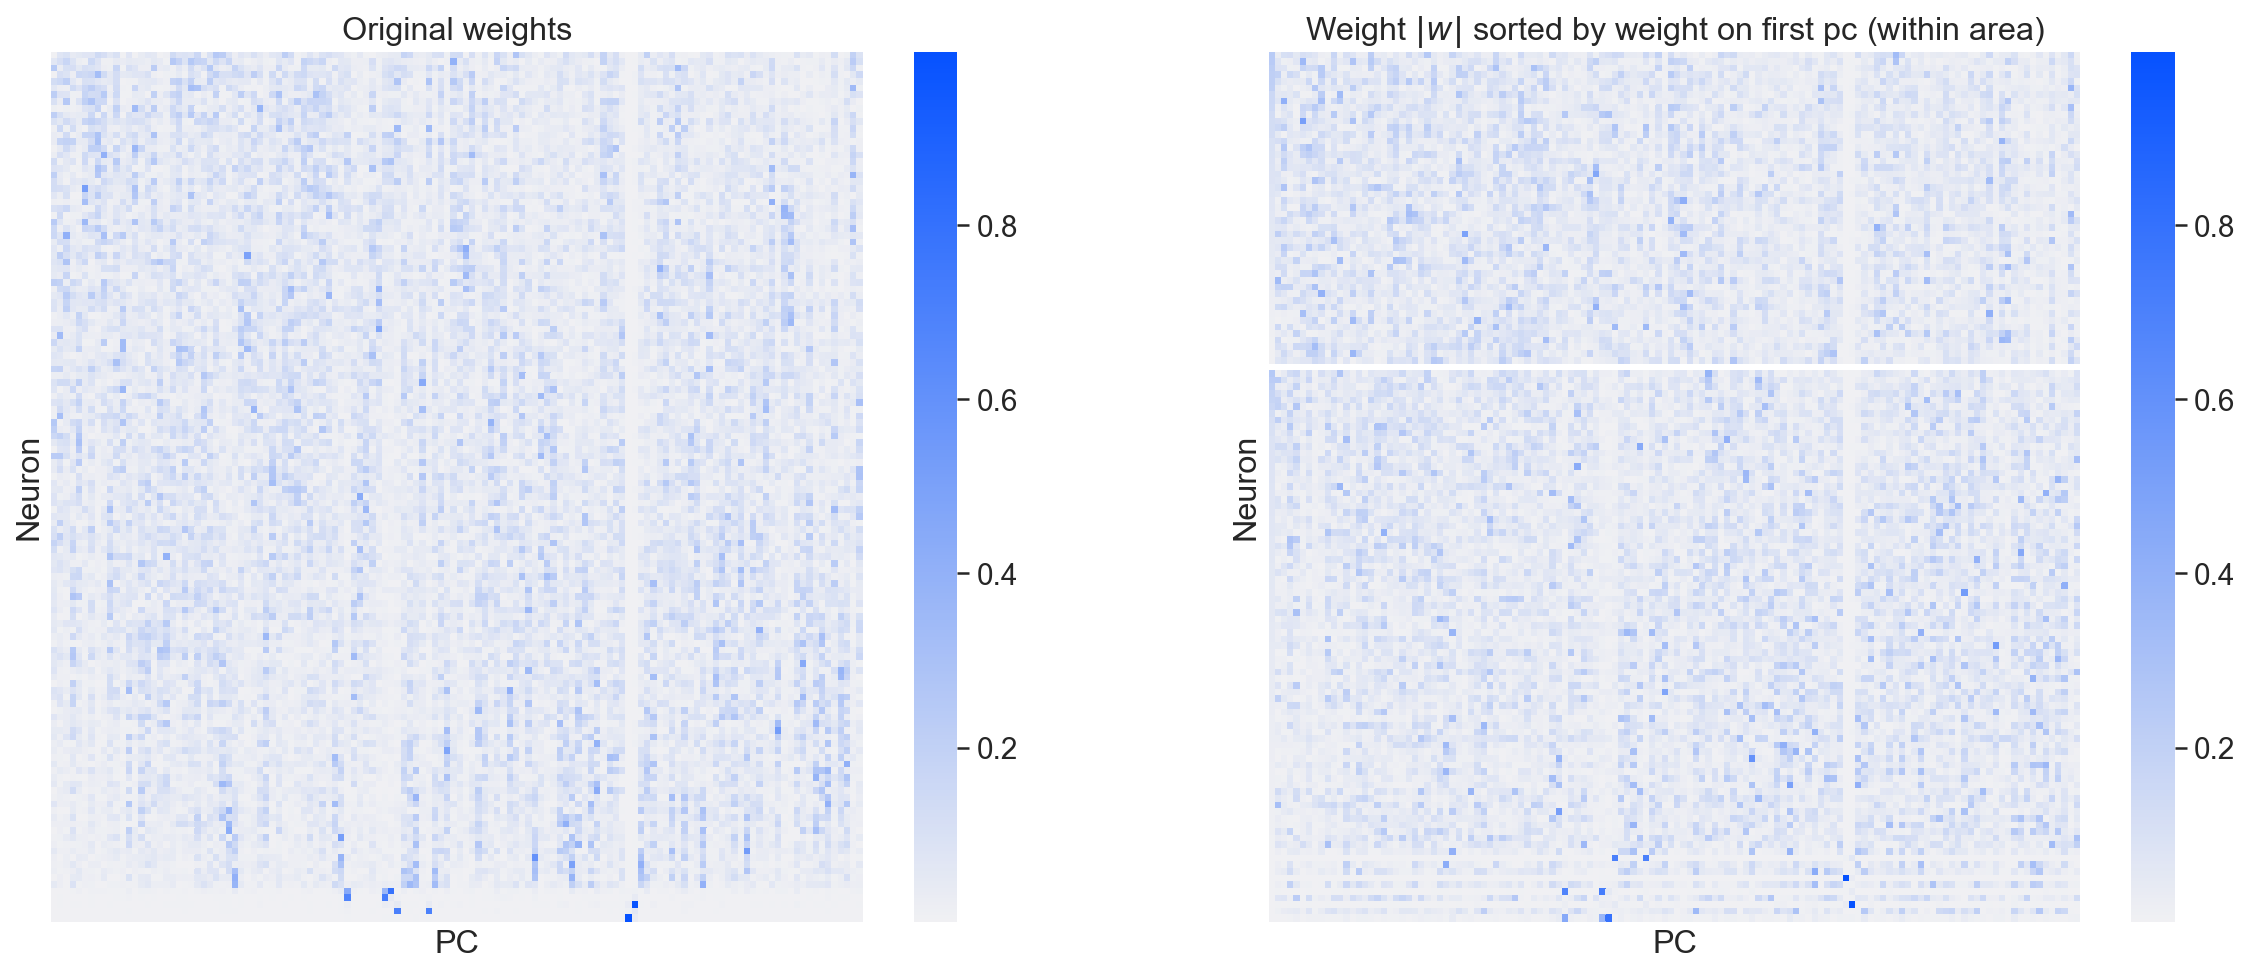

In [17]:
# Sort the principal component weights by the first pc (argsort).
M = sort_pcs_by(m1pmd_pcs, td['M1_spikes'][0], by=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(abs(m1pmd_pcs), cbar=True, ax=ax1, cmap=cmap, xticklabels=False, yticklabels=False)
ax1.set_title(r'Original weights')
ax1.set_xlabel('PC')
ax1.set_ylabel('Neuron')

sns.heatmap(M, cbar=True, ax=ax2, cmap=cmap, xticklabels=False, yticklabels=False)
ax2.set_title(r'Weight $|w|$ sorted by weight on first pc (within area)')
ax2.set_xlabel('PC')
ax2.set_ylabel('Neuron');

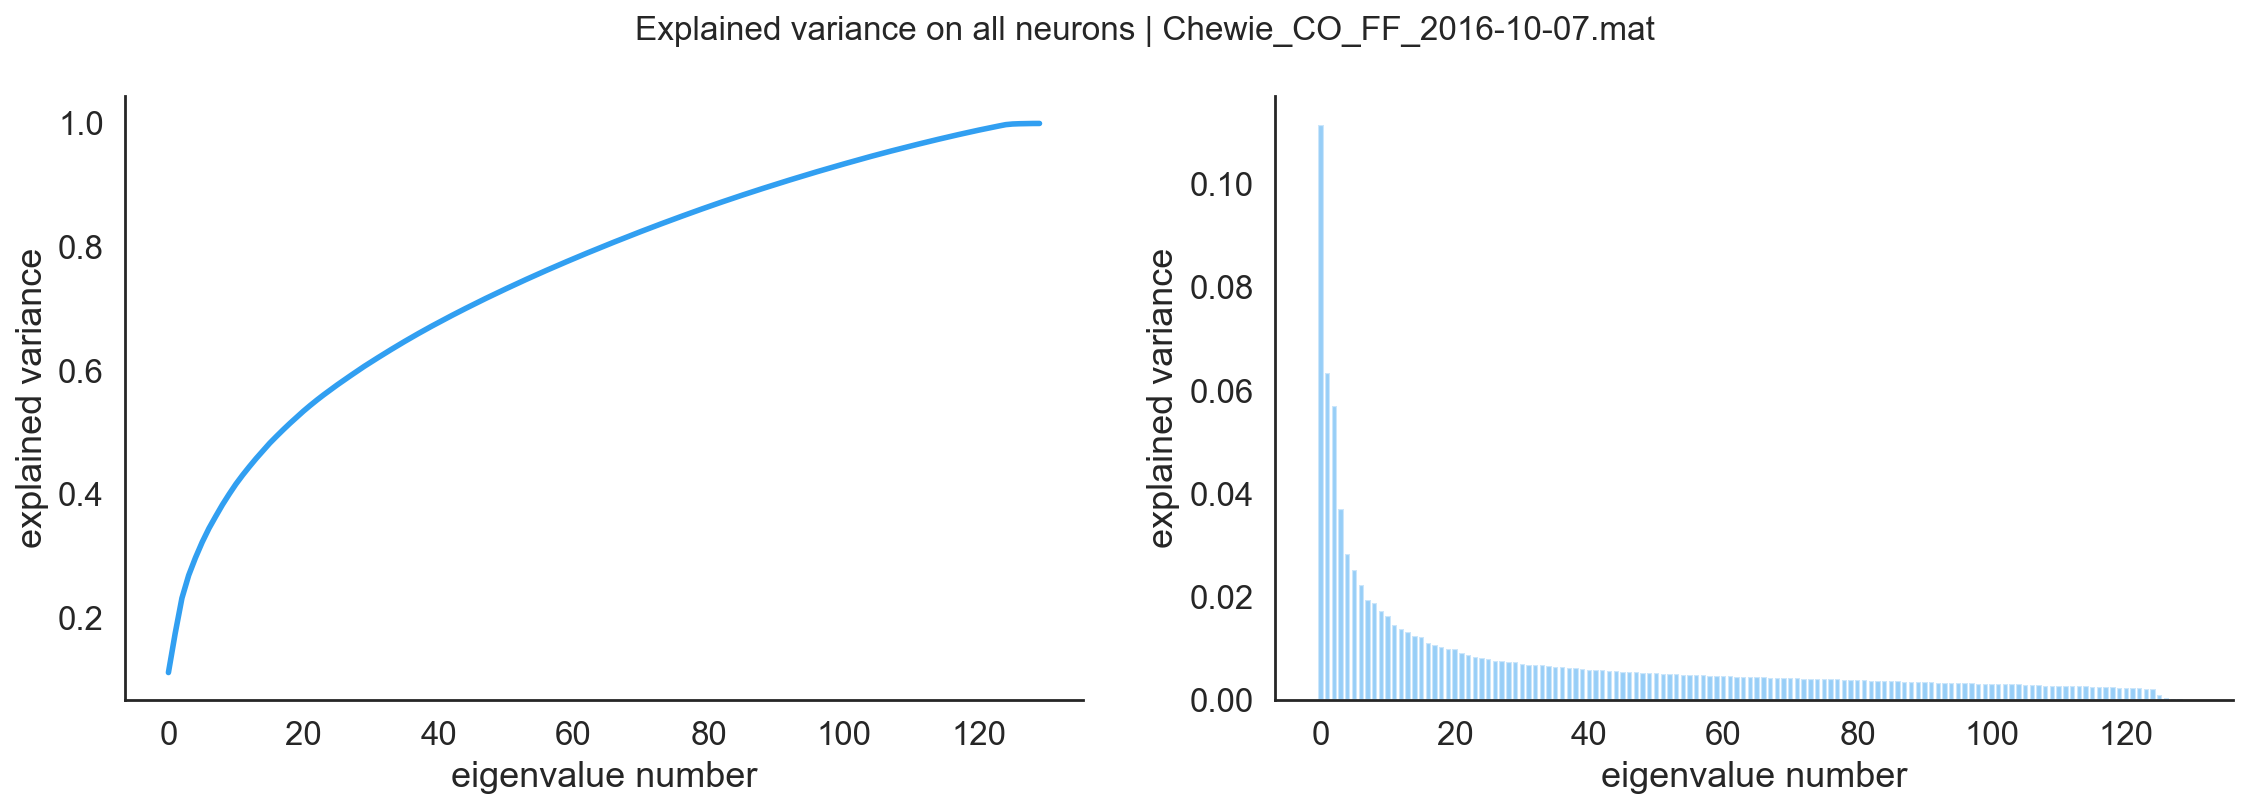

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5), dpi=80)
fig.suptitle(f'Explained variance on all neurons | {fname}', fontsize=15)
ax1.plot(m1pmd_var.cumsum(), lw=2.5)
ax1.set_xlabel('eigenvalue number')
ax1.set_ylabel('explained variance')

ax2.bar(range(0, len(m1pmd_var)), m1pmd_var, alpha=0.5, align='center')
ax2.set_xlabel('eigenvalue number')
ax2.set_ylabel('explained variance')
sns.despine(left=False, bottom=False);

### 2.2 Do PCA on PMd array

`PMd_rates`

In [19]:
pmd_pcs, pmd_var = getPCA(rates=td['PMd_rates']) 

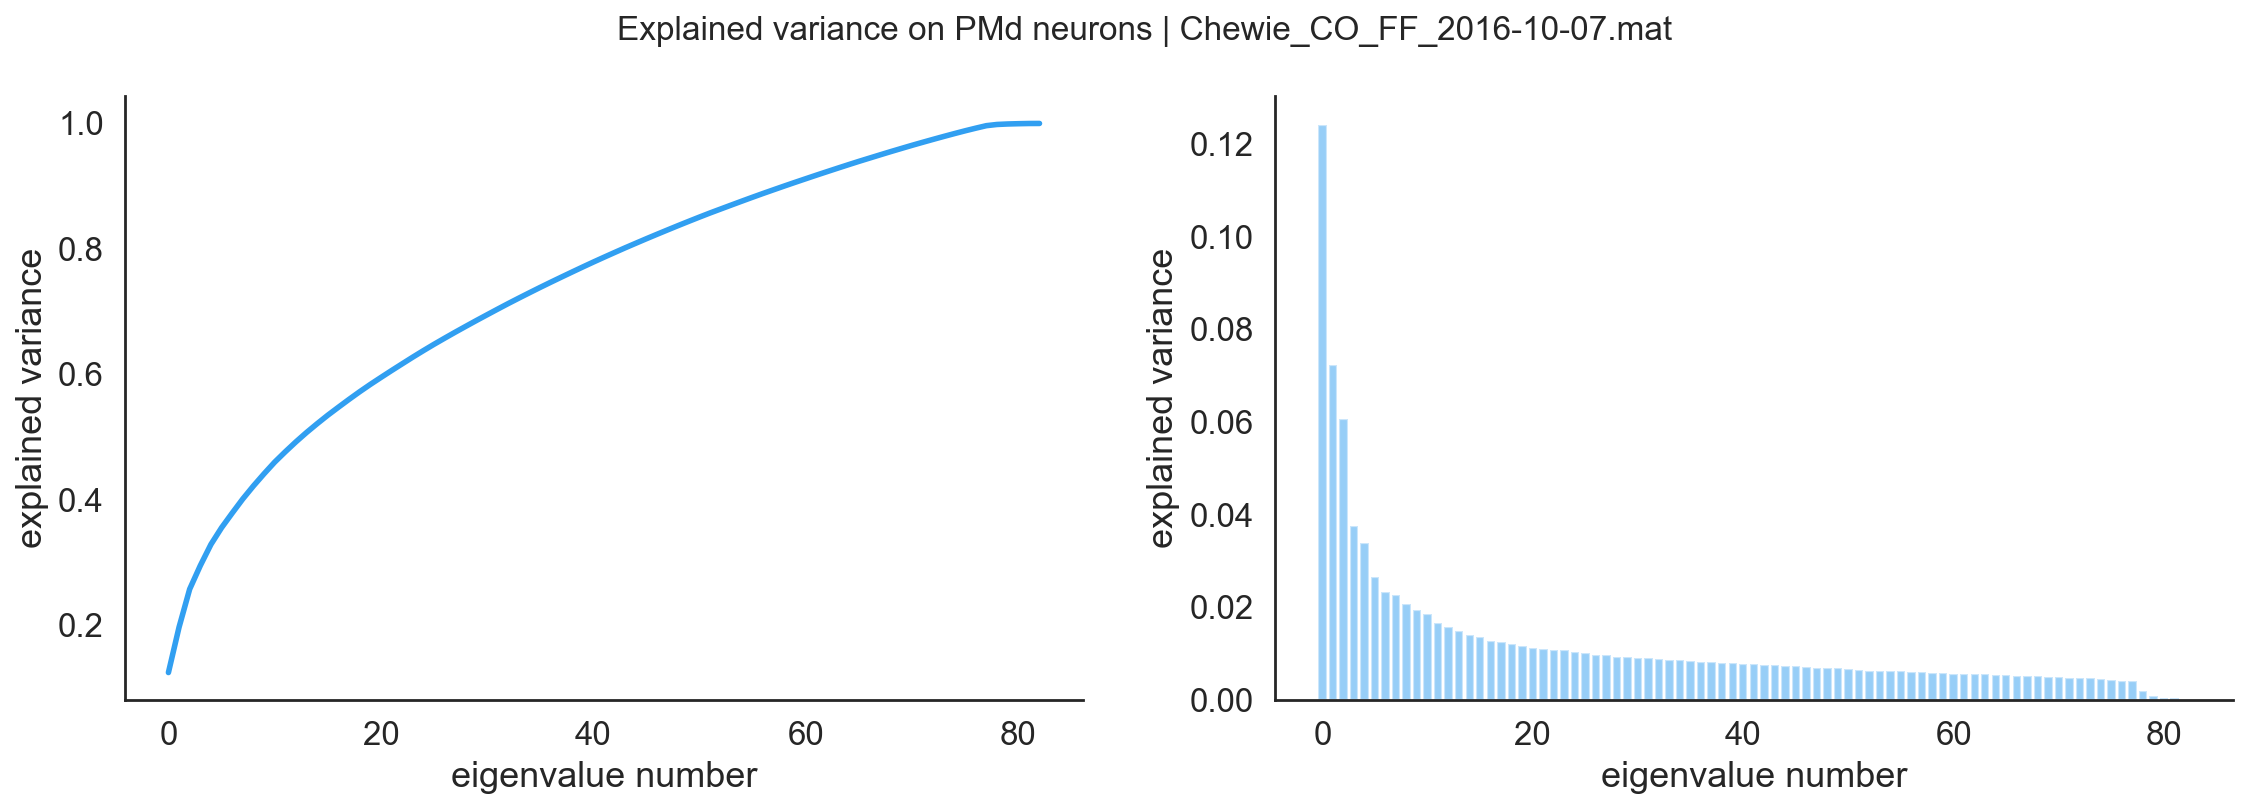

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5), dpi=80)
fig.suptitle(f'Explained variance on PMd neurons | {fname}', fontsize=15)
ax1.plot(pmd_var.cumsum(), lw=2.5)
ax1.set_xlabel('eigenvalue number')
ax1.set_ylabel('explained variance')

ax2.bar(range(0, len(pmd_var)), pmd_var, alpha=0.5, align='center')
ax2.set_xlabel('eigenvalue number')
ax2.set_ylabel('explained variance')
sns.despine();

### 2.3 Do PCA on M1 array

`M1_rates`

In [21]:
m1_pcs, m1_var = getPCA(rates=td['M1_rates']) 

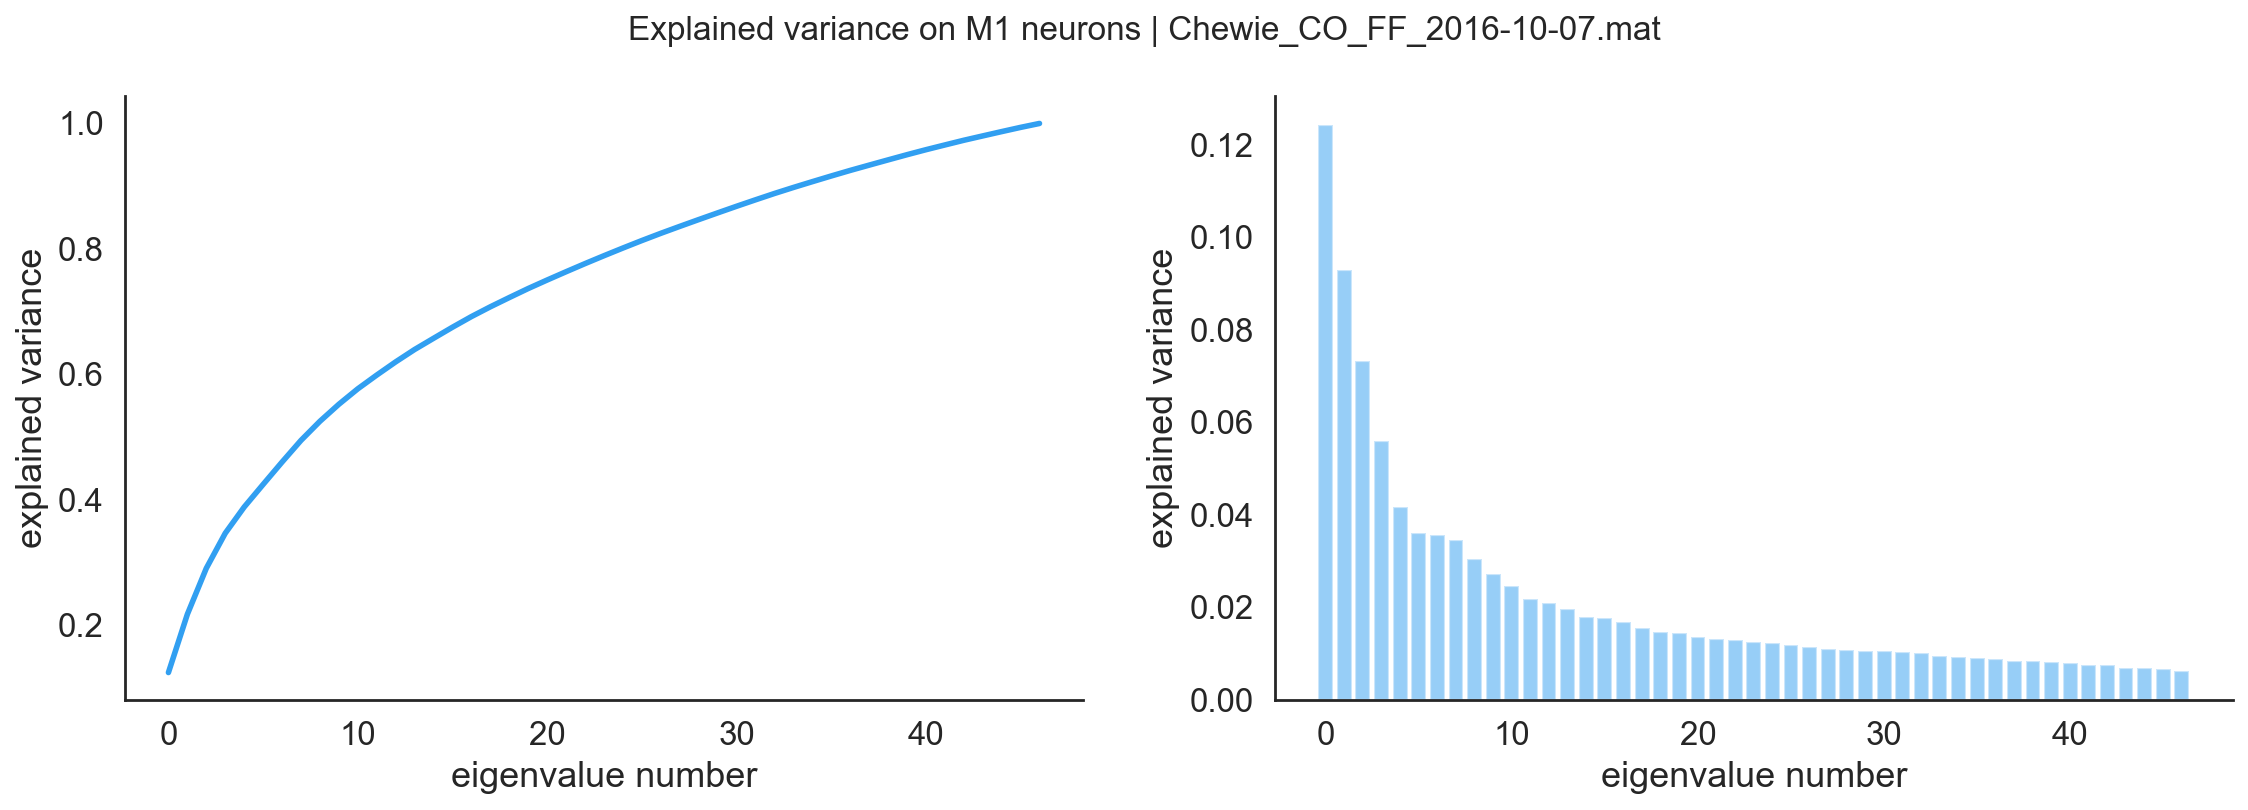

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5), dpi=80)
fig.suptitle(f'Explained variance on M1 neurons | {fname}', fontsize=15)
ax1.plot(m1_var.cumsum(), lw=2.5)
ax1.set_xlabel('eigenvalue number')
ax1.set_ylabel('explained variance')

ax2.bar(range(0, len(m1_var)), m1_var, alpha=0.5, align='center')
ax2.set_xlabel('eigenvalue number')
ax2.set_ylabel('explained variance')
sns.despine();

## 3 Analyse PC weights 

In [25]:
'''
Parameters
'''
binz = np.arange(0, 0.5, 0.005)

### 3.1 Read in cmp files & electrode maps

In [31]:
df_m1_arr  = read_cmp(file_path='/Users/Daphne/Desktop/Chewie Left M1 SN 6250-001474.cmp')
df_pmd_arr = read_cmp(file_path='/Users/Daphne/Desktop/Chewie Left PMd SN 6251-001469.cmp')

In [32]:
m1_elecmap  = localize_elecs(df_m1_arr, elecs=range(1,97))
pmd_elecmap = localize_elecs(df_pmd_arr, elecs=range(1,97))

### 3.2 Compare PC weights 

- within M1
- within PMd
- Between M1 & PMd

In [36]:
# choose from principal component to compare the weights
pc_num = 0

In [37]:
df = compare_pc_weights(m1_arr=m1_elecmap, m1_ug=td['M1_unit_guide'][0], pmd_arr=pmd_elecmap, pmd_ug=td['PMd_unit_guide'][0], w=m1pmd_pcs[:, pc_num])

df_m1_other  = df.loc[df['array'].isin(['M1', np.nan])]
df_pmd_other = df.loc[df['array'].isin(['PMd', np.nan])]
df_same_arr  = df.loc[df['group'] == 'same array']

m1_cats  = df_same_arr.loc[df['array']=='M1']
pmd_cats = df_same_arr.loc[df['array']=='PMd']

In [39]:
df.head()

,distance,w_diff,array,group,within arr distance
0,2.000000,0.061820,M1,same array,0 - 3
1,3.000000,0.239064,M1,same array,0 - 3
2,4.000000,0.004341,M1,same array,3 - 6
3,1.414214,0.125747,M1,same array,0 - 3
4,1.000000,0.063376,M1,same array,0 - 3


In [40]:
df.groupby(['group']).describe()

distance                                                   \
               count     mean       std  min       25%  50%       75%   
group                                                                   
other array      0.0      NaN       NaN  NaN       NaN  NaN       NaN   
same array    4409.0  4.95324  2.326024  1.0  3.162278  5.0  6.403124   
same elec       75.0  0.00000  0.000000  0.0  0.000000  0.0  0.000000   

                        w_diff                                          \
                   max   count      mean       std       min       25%   
group                                                                    
other array        NaN  3901.0  0.089386  0.070072  0.000016  0.034271   
same array   11.401754  4409.0  0.118630  0.091009  0.000088  0.046281   
same elec     0.000000    75.0  0.131002  0.099536  0.002112  0.060523   

                                           
                  50%       75%       max  
group                                      
other array  0.072805  0.127971  0.340471  
same array   0.097975  0.171904  0.491117  
same elec    0.107533  0.186235  0.459501

In [41]:
df.groupby(['array']).describe()

distance                                                               \
         count      mean       std  min  25%       50%       75%        max   
array                                                                         
M1      1081.0  4.788431  2.345144  0.0  3.0  4.472136  6.403124  11.401754   
PMd     3403.0  4.896428  2.406943  0.0  3.0  5.000000  6.403124  11.401754   

       w_diff                                                              \
        count      mean       std       min       25%       50%       75%   
array                                                                       
M1     1081.0  0.121656  0.092056  0.000823  0.048591  0.100152  0.175726   
PMd    3403.0  0.117941  0.090868  0.000088  0.045814  0.097649  0.170399   

                 
            max  
array            
M1     0.476872  
PMd    0.491117

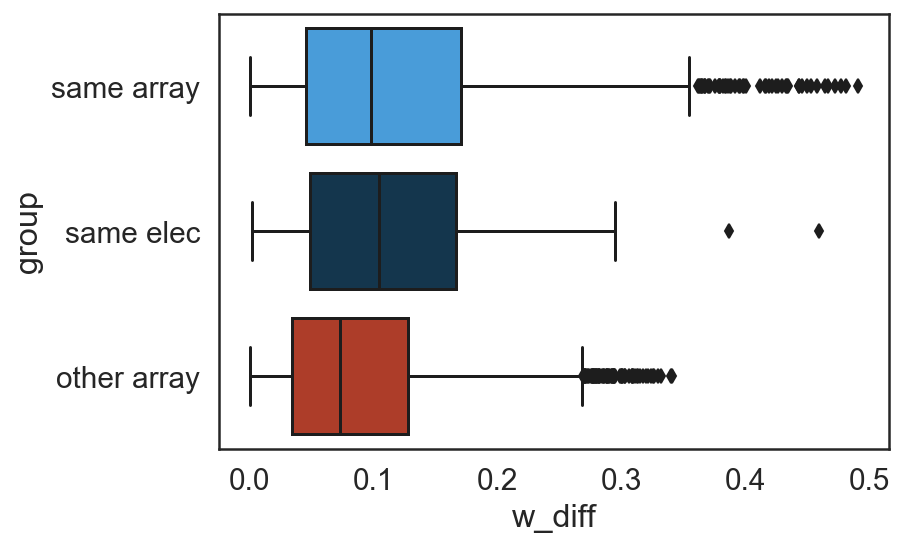

In [45]:
sns.boxplot(data=df_pmd_other, x='w_diff', y='group');

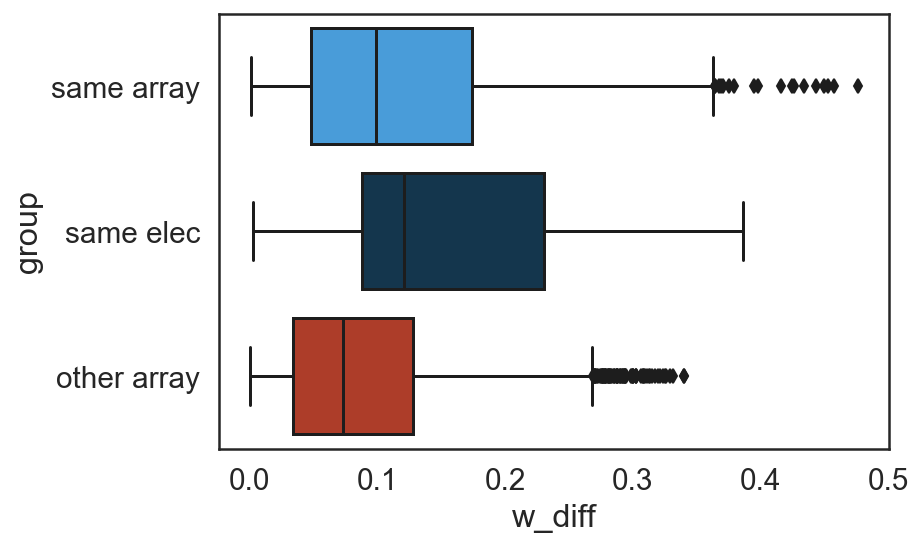

In [46]:
sns.boxplot(data=df_m1_other, x='w_diff', y='group');

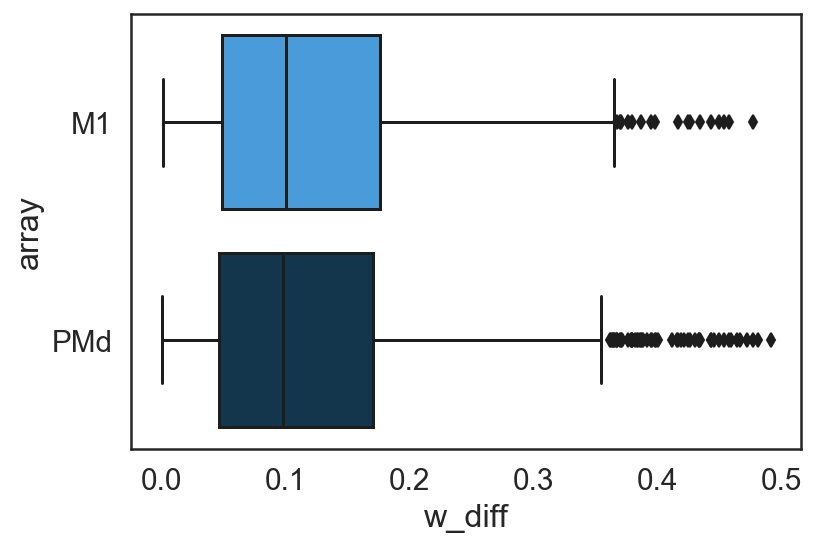

In [47]:
sns.boxplot(data=df, x='w_diff', y='array');

### 3.4 Plot weight difference distributions

In [48]:
def generate_weight_distrib(pc_num):
    
    # compare weights of pc number K
    df = compare_pc_weights(m1_arr=m1_elecmap, m1_ug=td['M1_unit_guide'][0], pmd_arr=pmd_elecmap, pmd_ug=td['PMd_unit_guide'][0], w=m1pmd_pcs[:, pc_num])
    
    df_m1  = df.loc[df['array'].isin(['M1', np.nan])]
    df_pmd = df.loc[df['array'].isin(['PMd', np.nan])]
    df_same_arr = df.loc[df['group'] == 'same array']
    # make within categories
    m1_cats = df_same_arr.loc[df['array']=='M1']
    pmd_cats = df_same_arr.loc[df['array']=='PMd']

    
    # Generate 2 x 2 plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle(f'pc number {pc_num + 1}', fontsize=18)
    
    # global settings
    binz = np.arange(0, 0.5, 0.005)
    xbar = [str(bin) for bin in binz]
    intvals = np.append(binz, np.inf)
    
    # M1
    se = df_m1.loc[df_m1['group'] == 'same elec']['w_diff'].values
    sa = df_m1.loc[df_m1['group'] == 'same array']['w_diff'].values
    oa = df_m1.loc[df_m1['group'] == 'other array']['w_diff'].values

    ax1.set_title('pc weight distribution M1, sorted by group')
    oa_bins = [np.sum((oa >= intvals[i]) & (oa < intvals[i + 1])) for i in range(len(binz))]
    oa_bins = oa_bins / max(oa_bins)
    ax1.bar(x=xbar, height=oa_bins, label='Other array')

    sa_bins = [np.sum((sa >= intvals[i]) & (sa < intvals[i + 1])) for i in range(len(binz))]
    sa_bins = sa_bins / max(sa_bins)
    ax1.bar(x=xbar, height=sa_bins, label='Same array', alpha=.7)

    se_bins = [np.sum((se >= intvals[i]) & (se < intvals[i + 1])) for i in range(len(binz))]
    se_bins = se_bins / max(se_bins)
    ax1.bar(x=xbar, height=se_bins,  label='Same electrode', alpha=.7)
    ax1.set_xlabel(r'$w_{diff}$')
    ax1.set_xticks([str(i / 10) for i in range(0, 6)])
    
    # PMD
    se = df_pmd.loc[df_pmd['group'] == 'same elec']['w_diff'].values
    sa = df_pmd.loc[df_pmd['group'] == 'same array']['w_diff'].values
    oa = df_pmd.loc[df_pmd['group'] == 'other array']['w_diff'].values
    
    ax2.set_title('pc weight distribution PMd, sorted by group')
    oa_bins = [np.sum((oa >= intvals[i]) & (oa < intvals[i + 1])) for i in range(len(binz))]
    oa_bins = oa_bins / max(oa_bins)
    ax2.bar(x=xbar, height=oa_bins, label='Other array')

    sa_bins = [np.sum((sa >= intvals[i]) & (sa < intvals[i + 1])) for i in range(len(binz))]
    sa_bins = sa_bins / max(sa_bins)
    ax2.bar(x=xbar, height=sa_bins, label='Same array', alpha=.7)

    se_bins = [np.sum((se >= intvals[i]) & (se < intvals[i + 1])) for i in range(len(binz))]
    se_bins = se_bins / max(se_bins)
    ax2.bar(x=xbar, height=se_bins,  label='Same electrode', alpha=.7)
    ax2.set_xlabel(r'$w_{diff}$')
    ax2.set_xticks([str(i / 10) for i in range(0, 6)])
    ax2.legend()
    sns.despine()
    
    # within array plots with seaborn (not scaled)
    sns.histplot(m1_cats, x='w_diff', hue='within arr distance', bins=binz, stat='count', ax=ax3, multiple='stack')
    ax3.set_title('Within M1 array weight differences')
    ax3.set_xlabel(r'$w_{diff}$')

    sns.histplot(pmd_cats, x='w_diff', hue='within arr distance', bins=binz, stat='count', ax=ax4, multiple='stack')
    ax4.set_title('Within PMd array weight differences')
    ax4.set_xlabel(r'$w_{diff}$')
    sns.despine()
    plt.tight_layout()

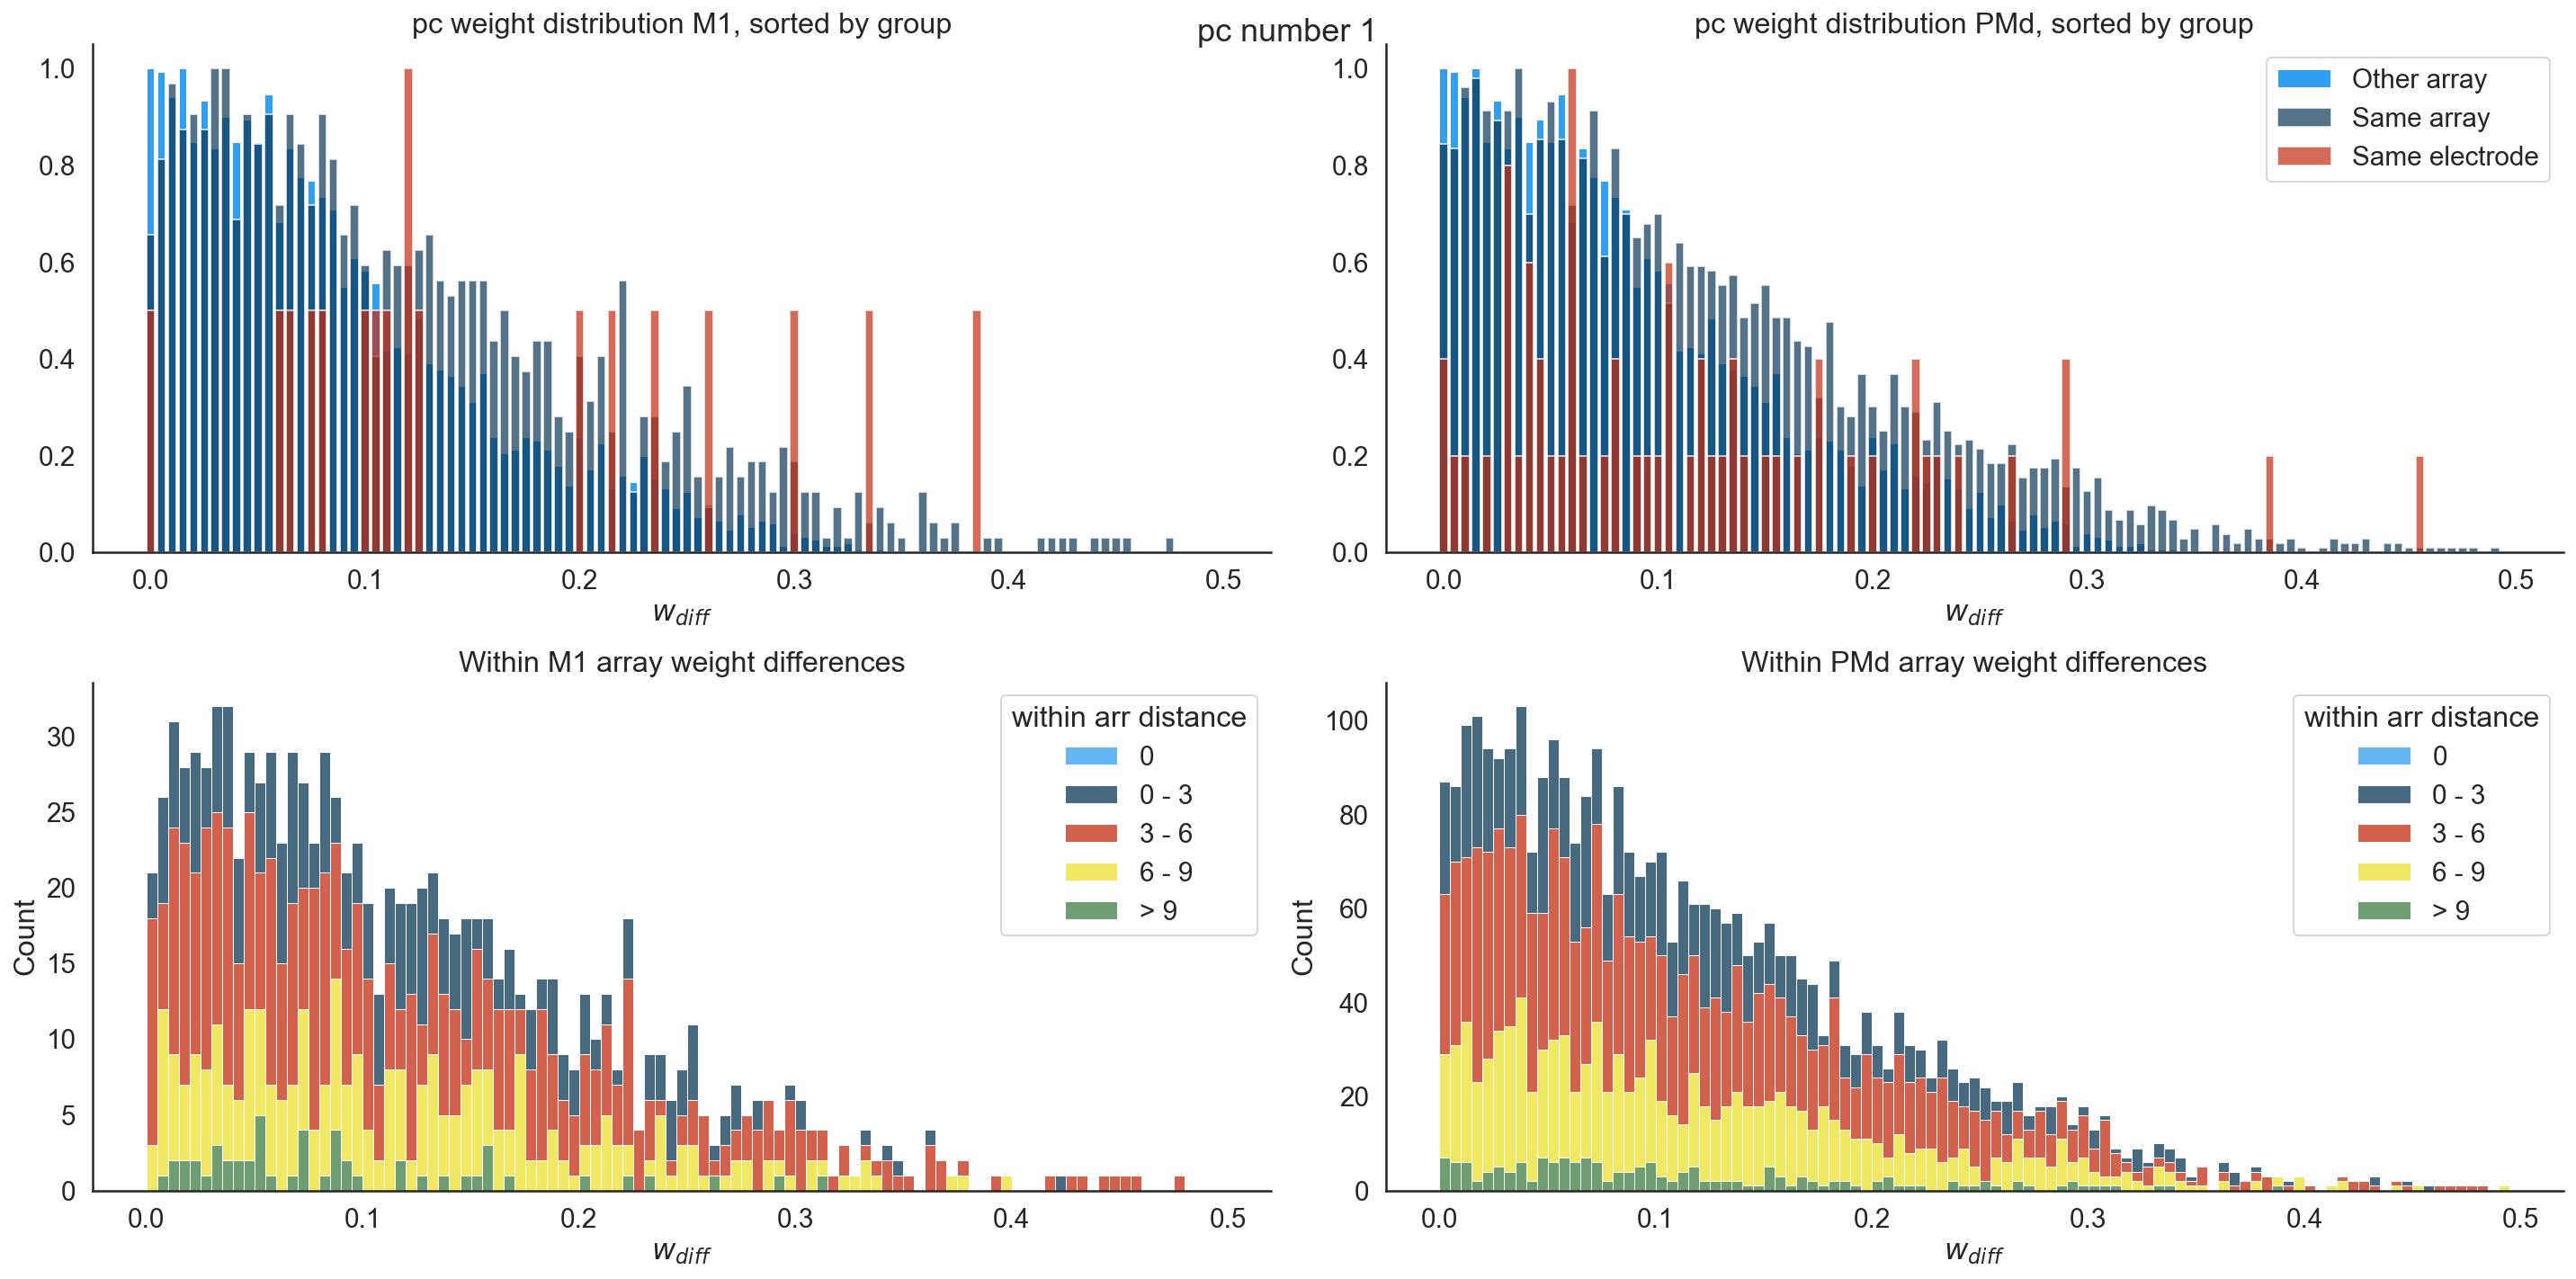

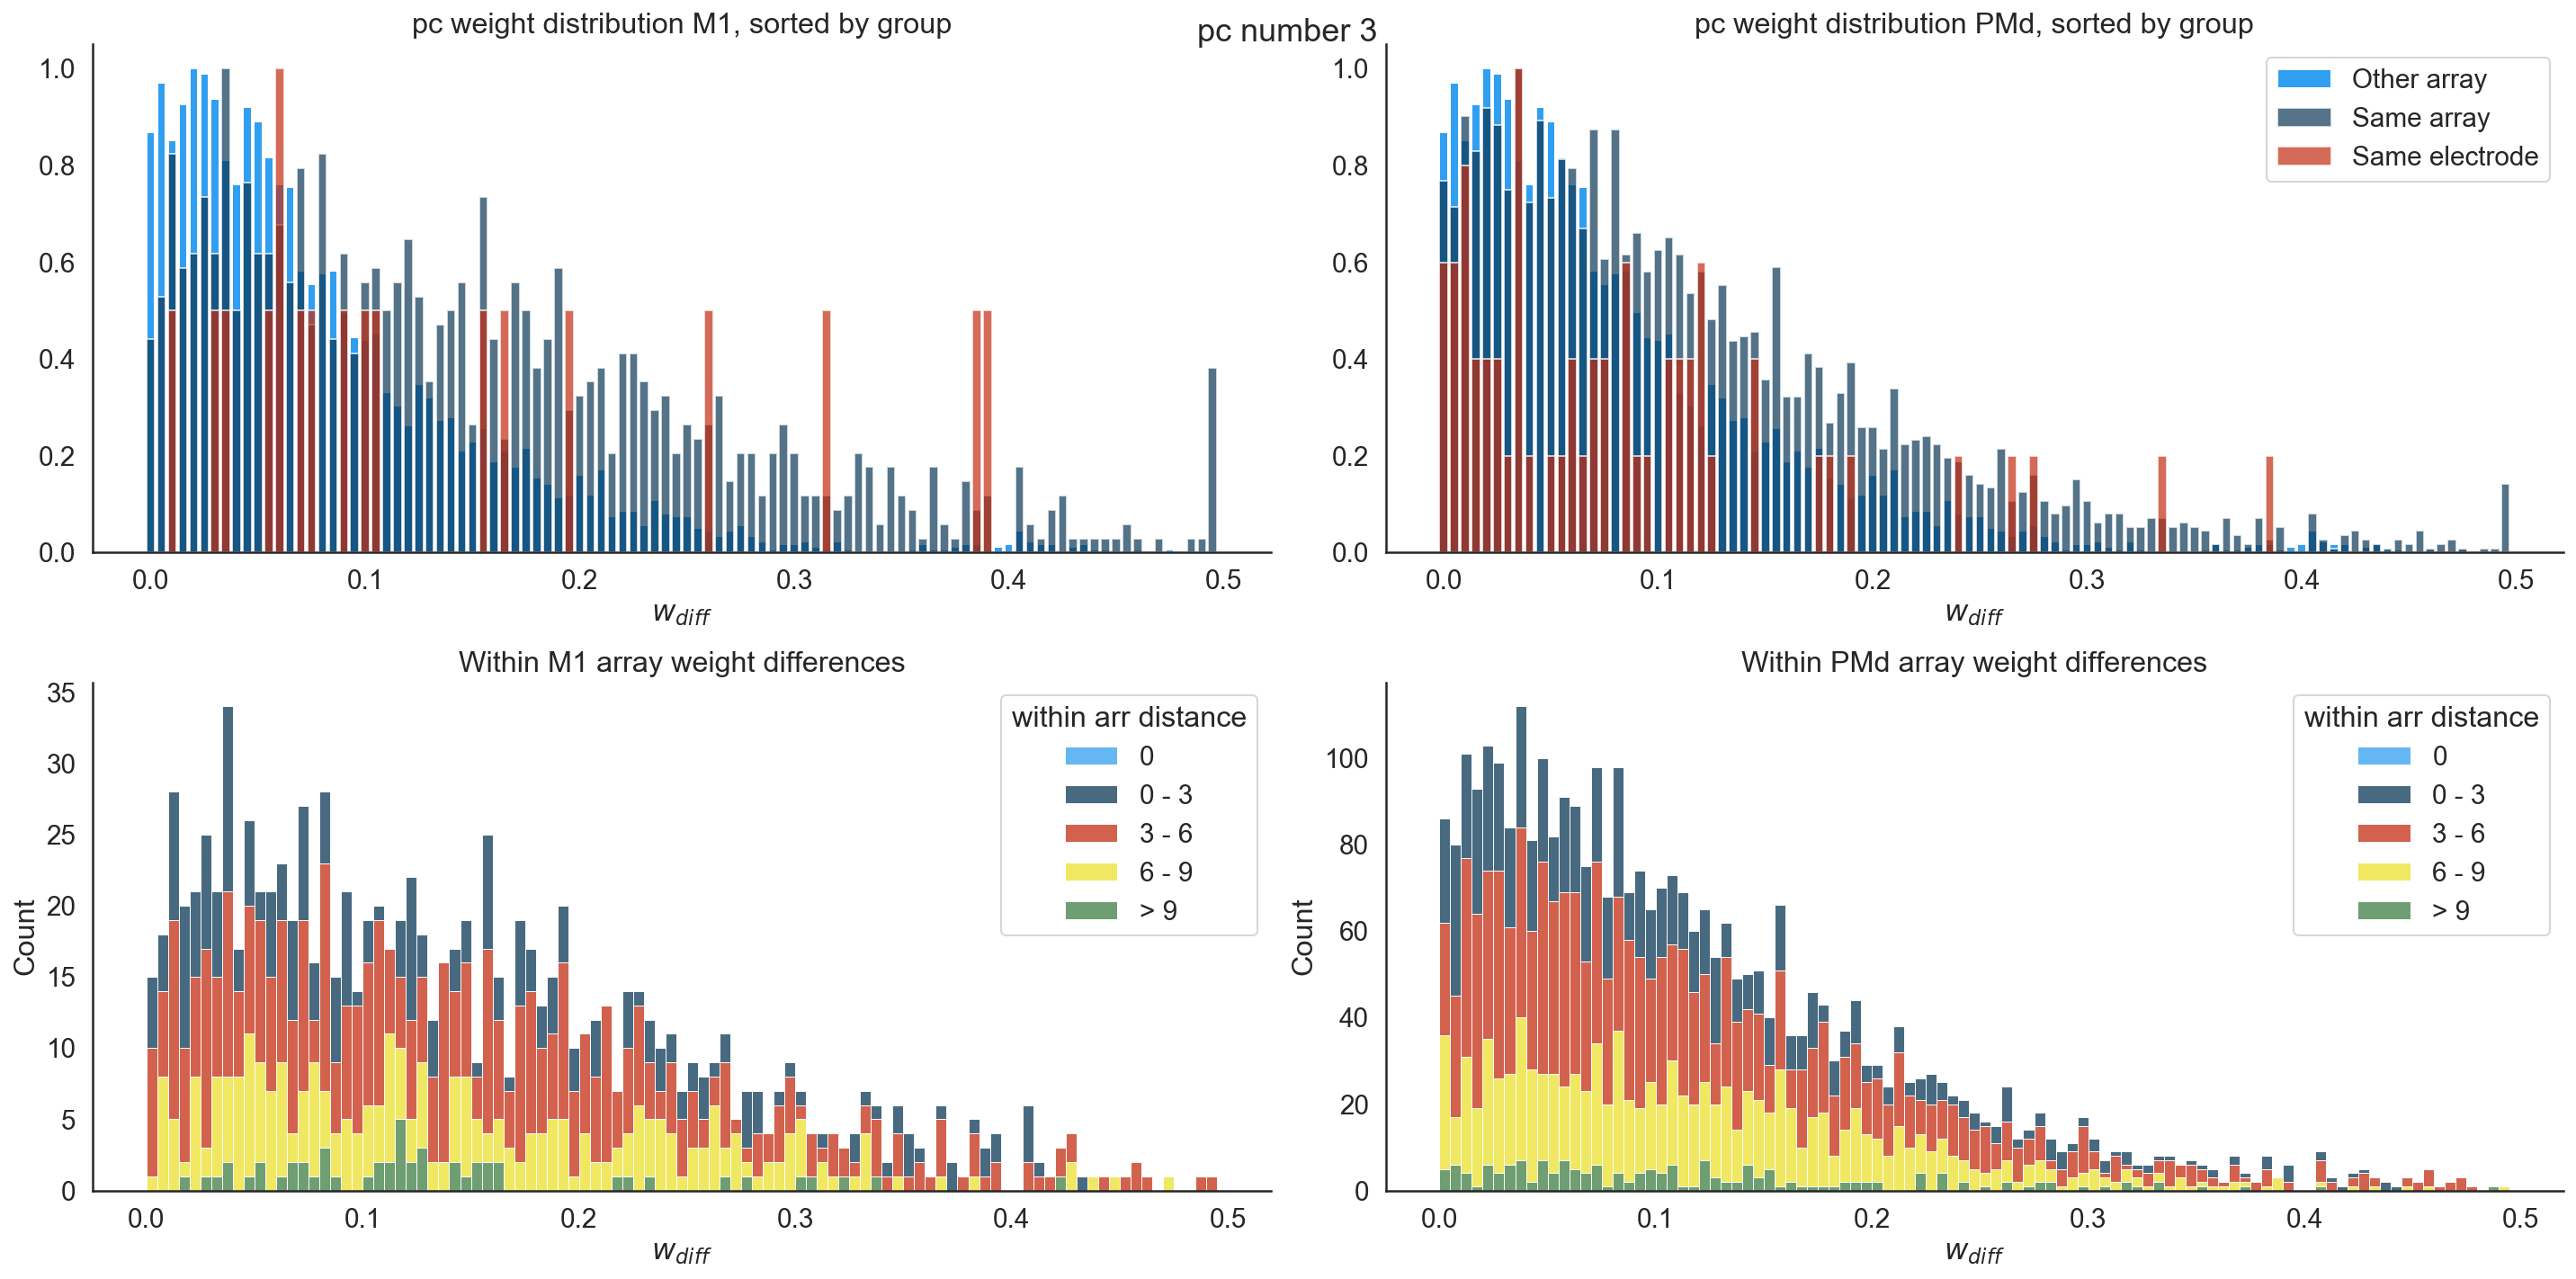

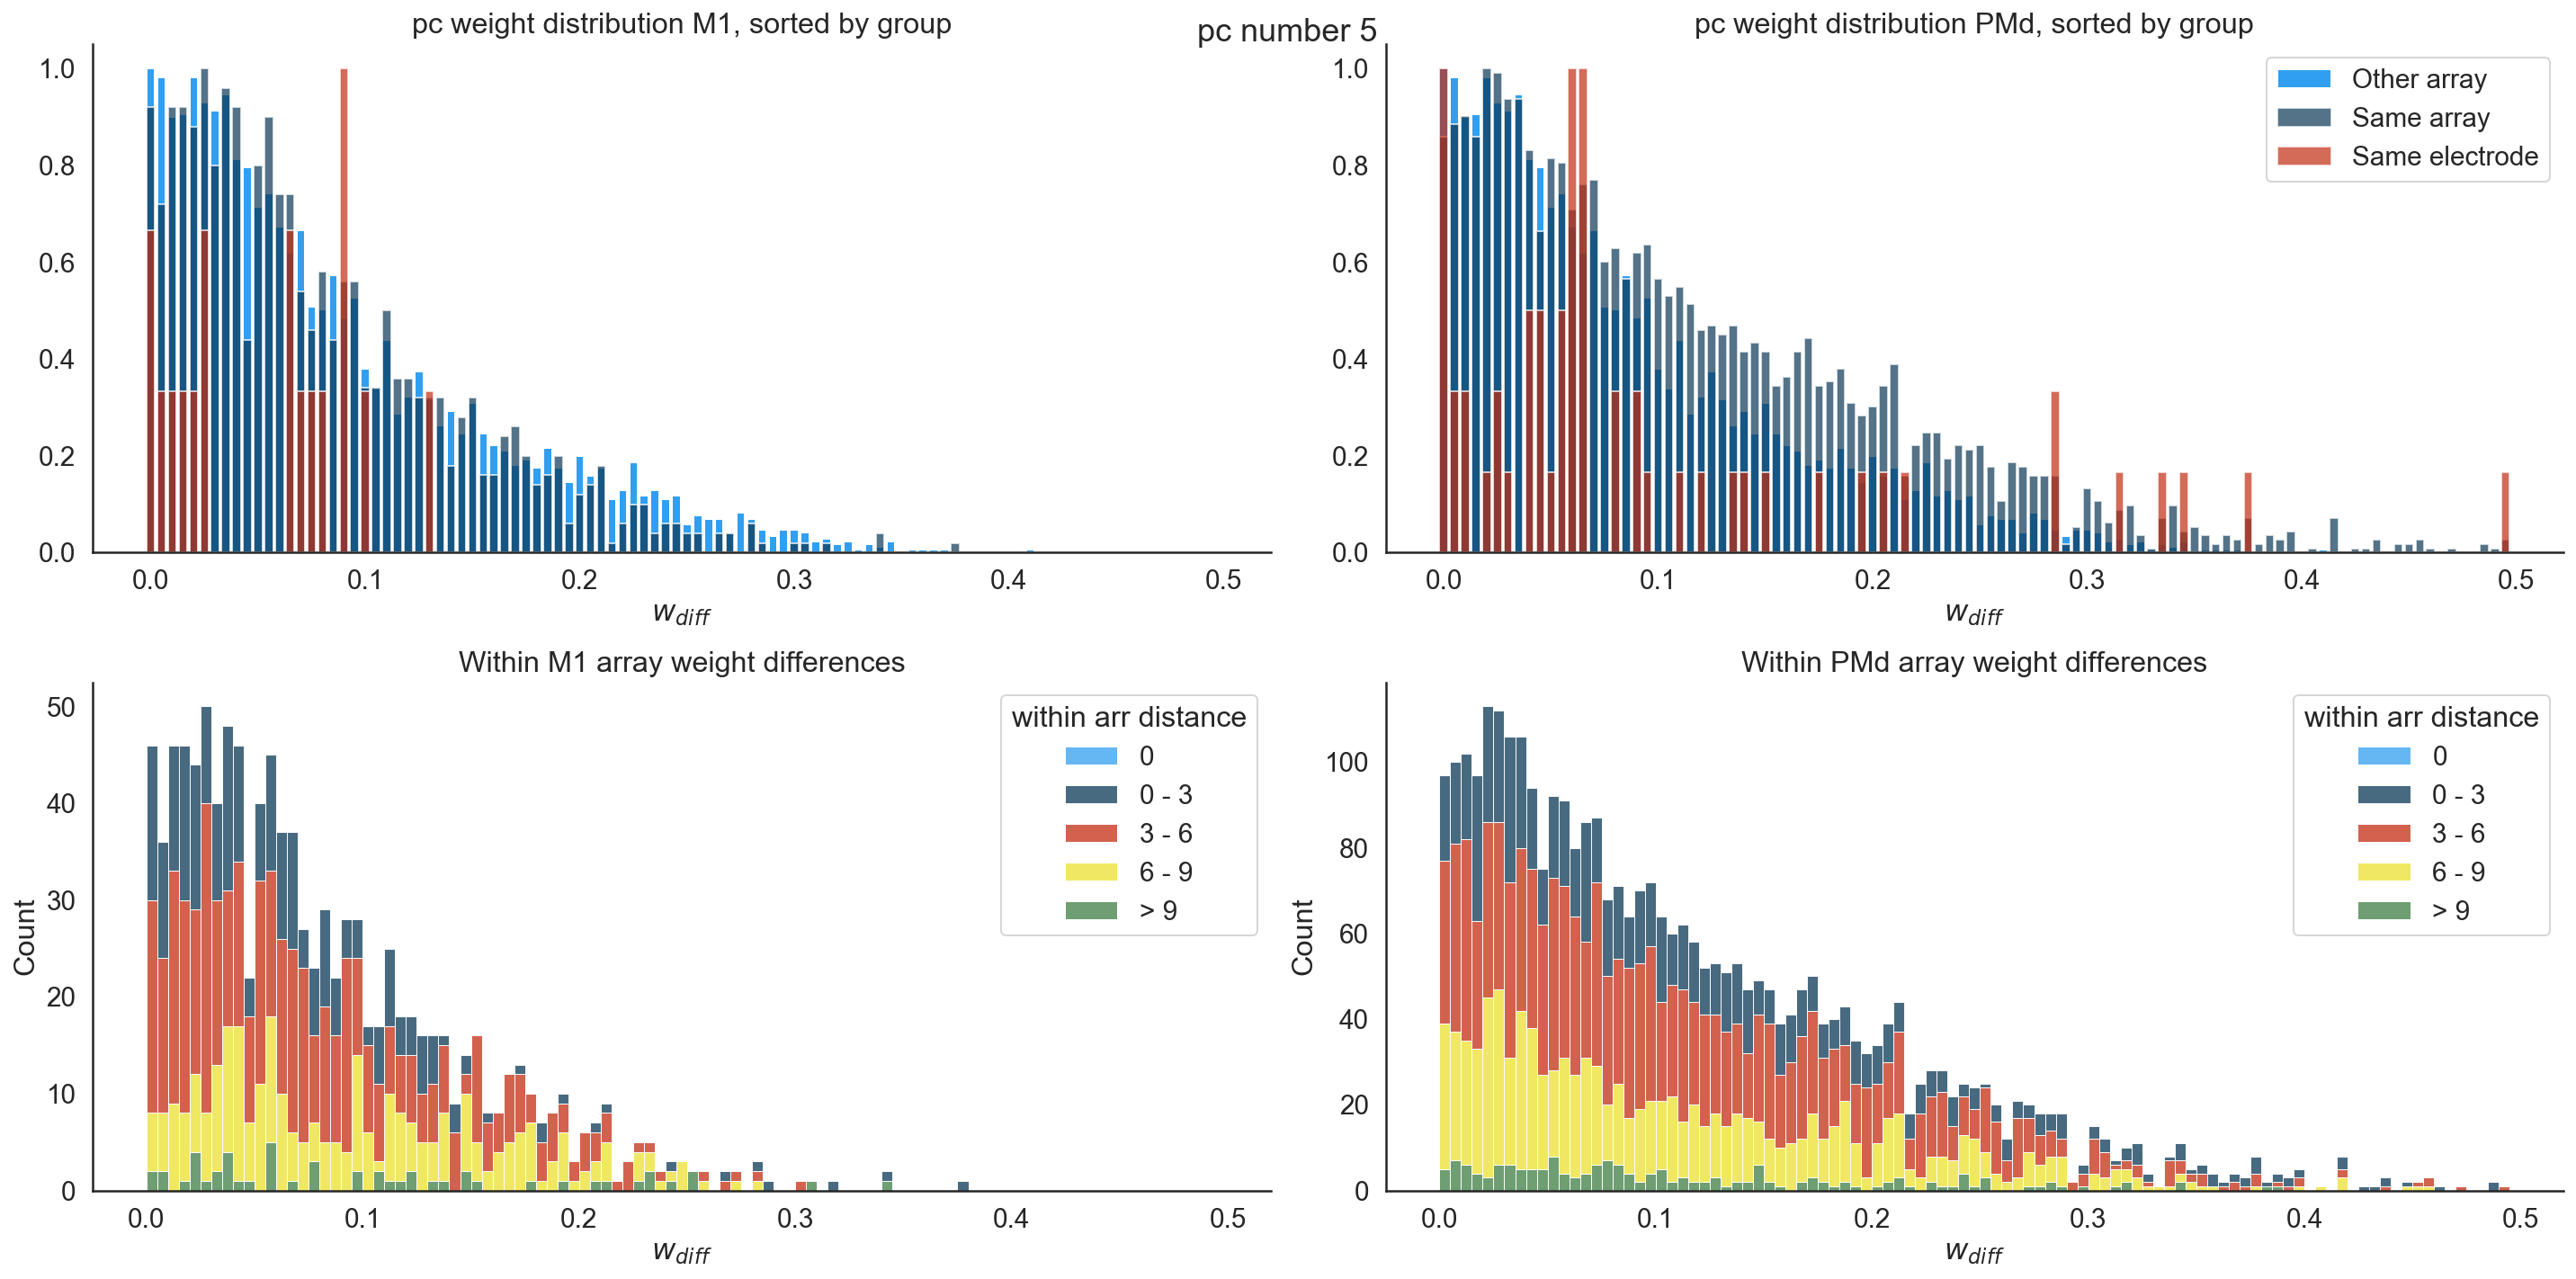

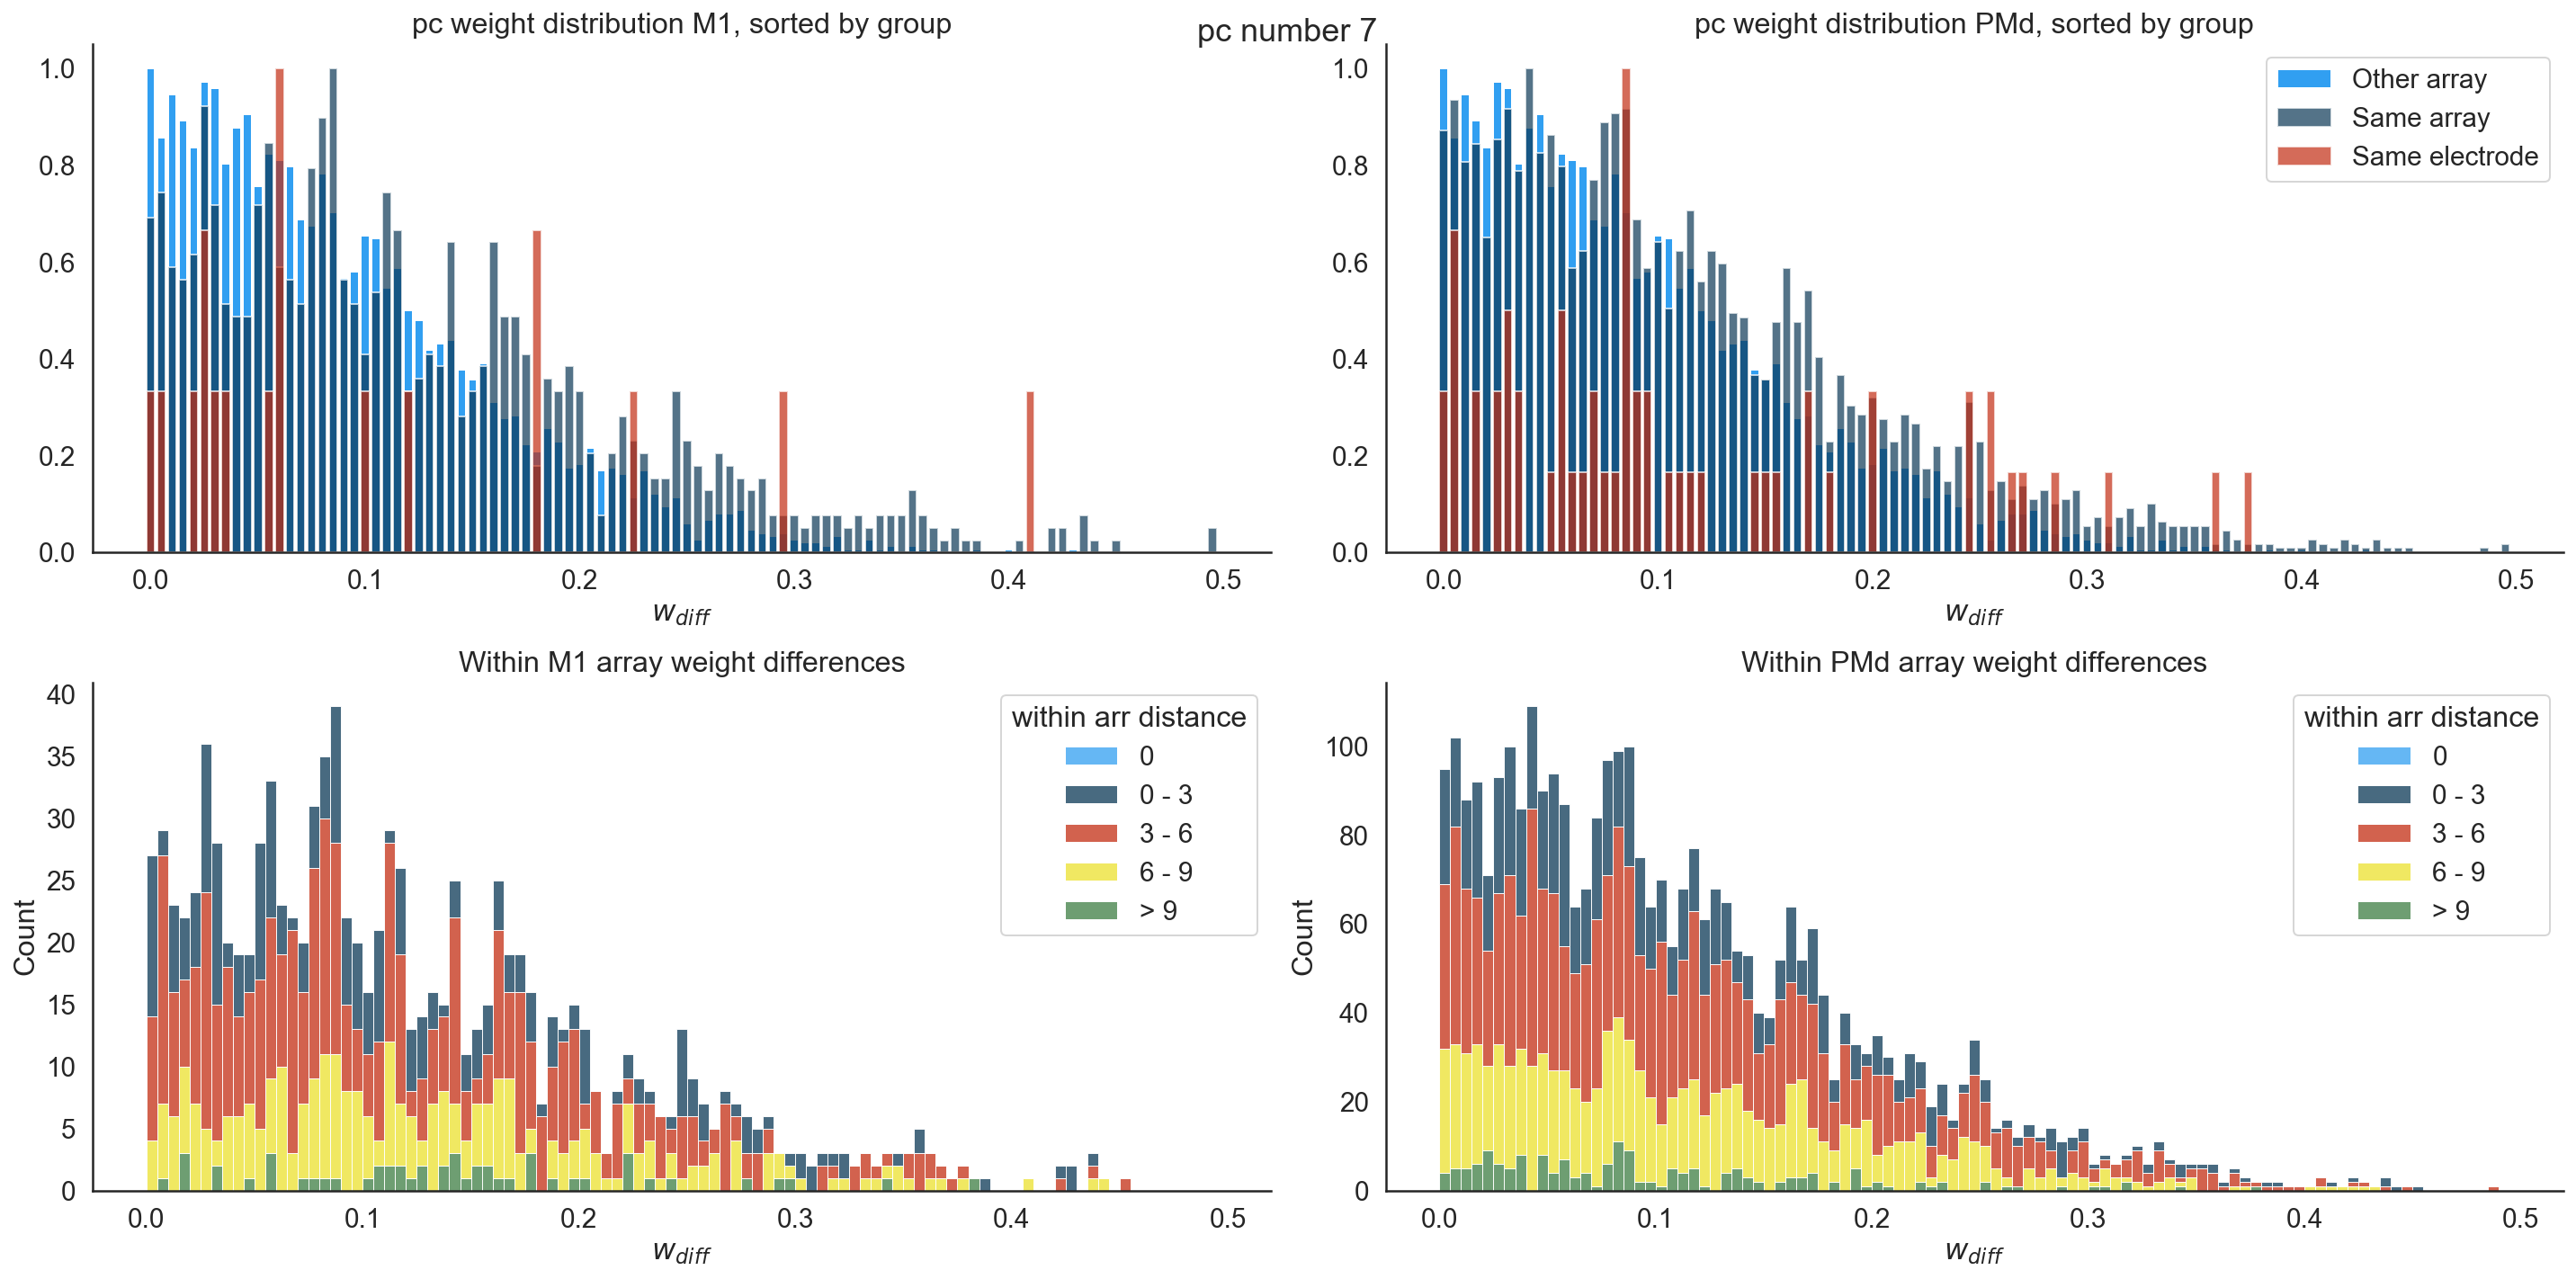

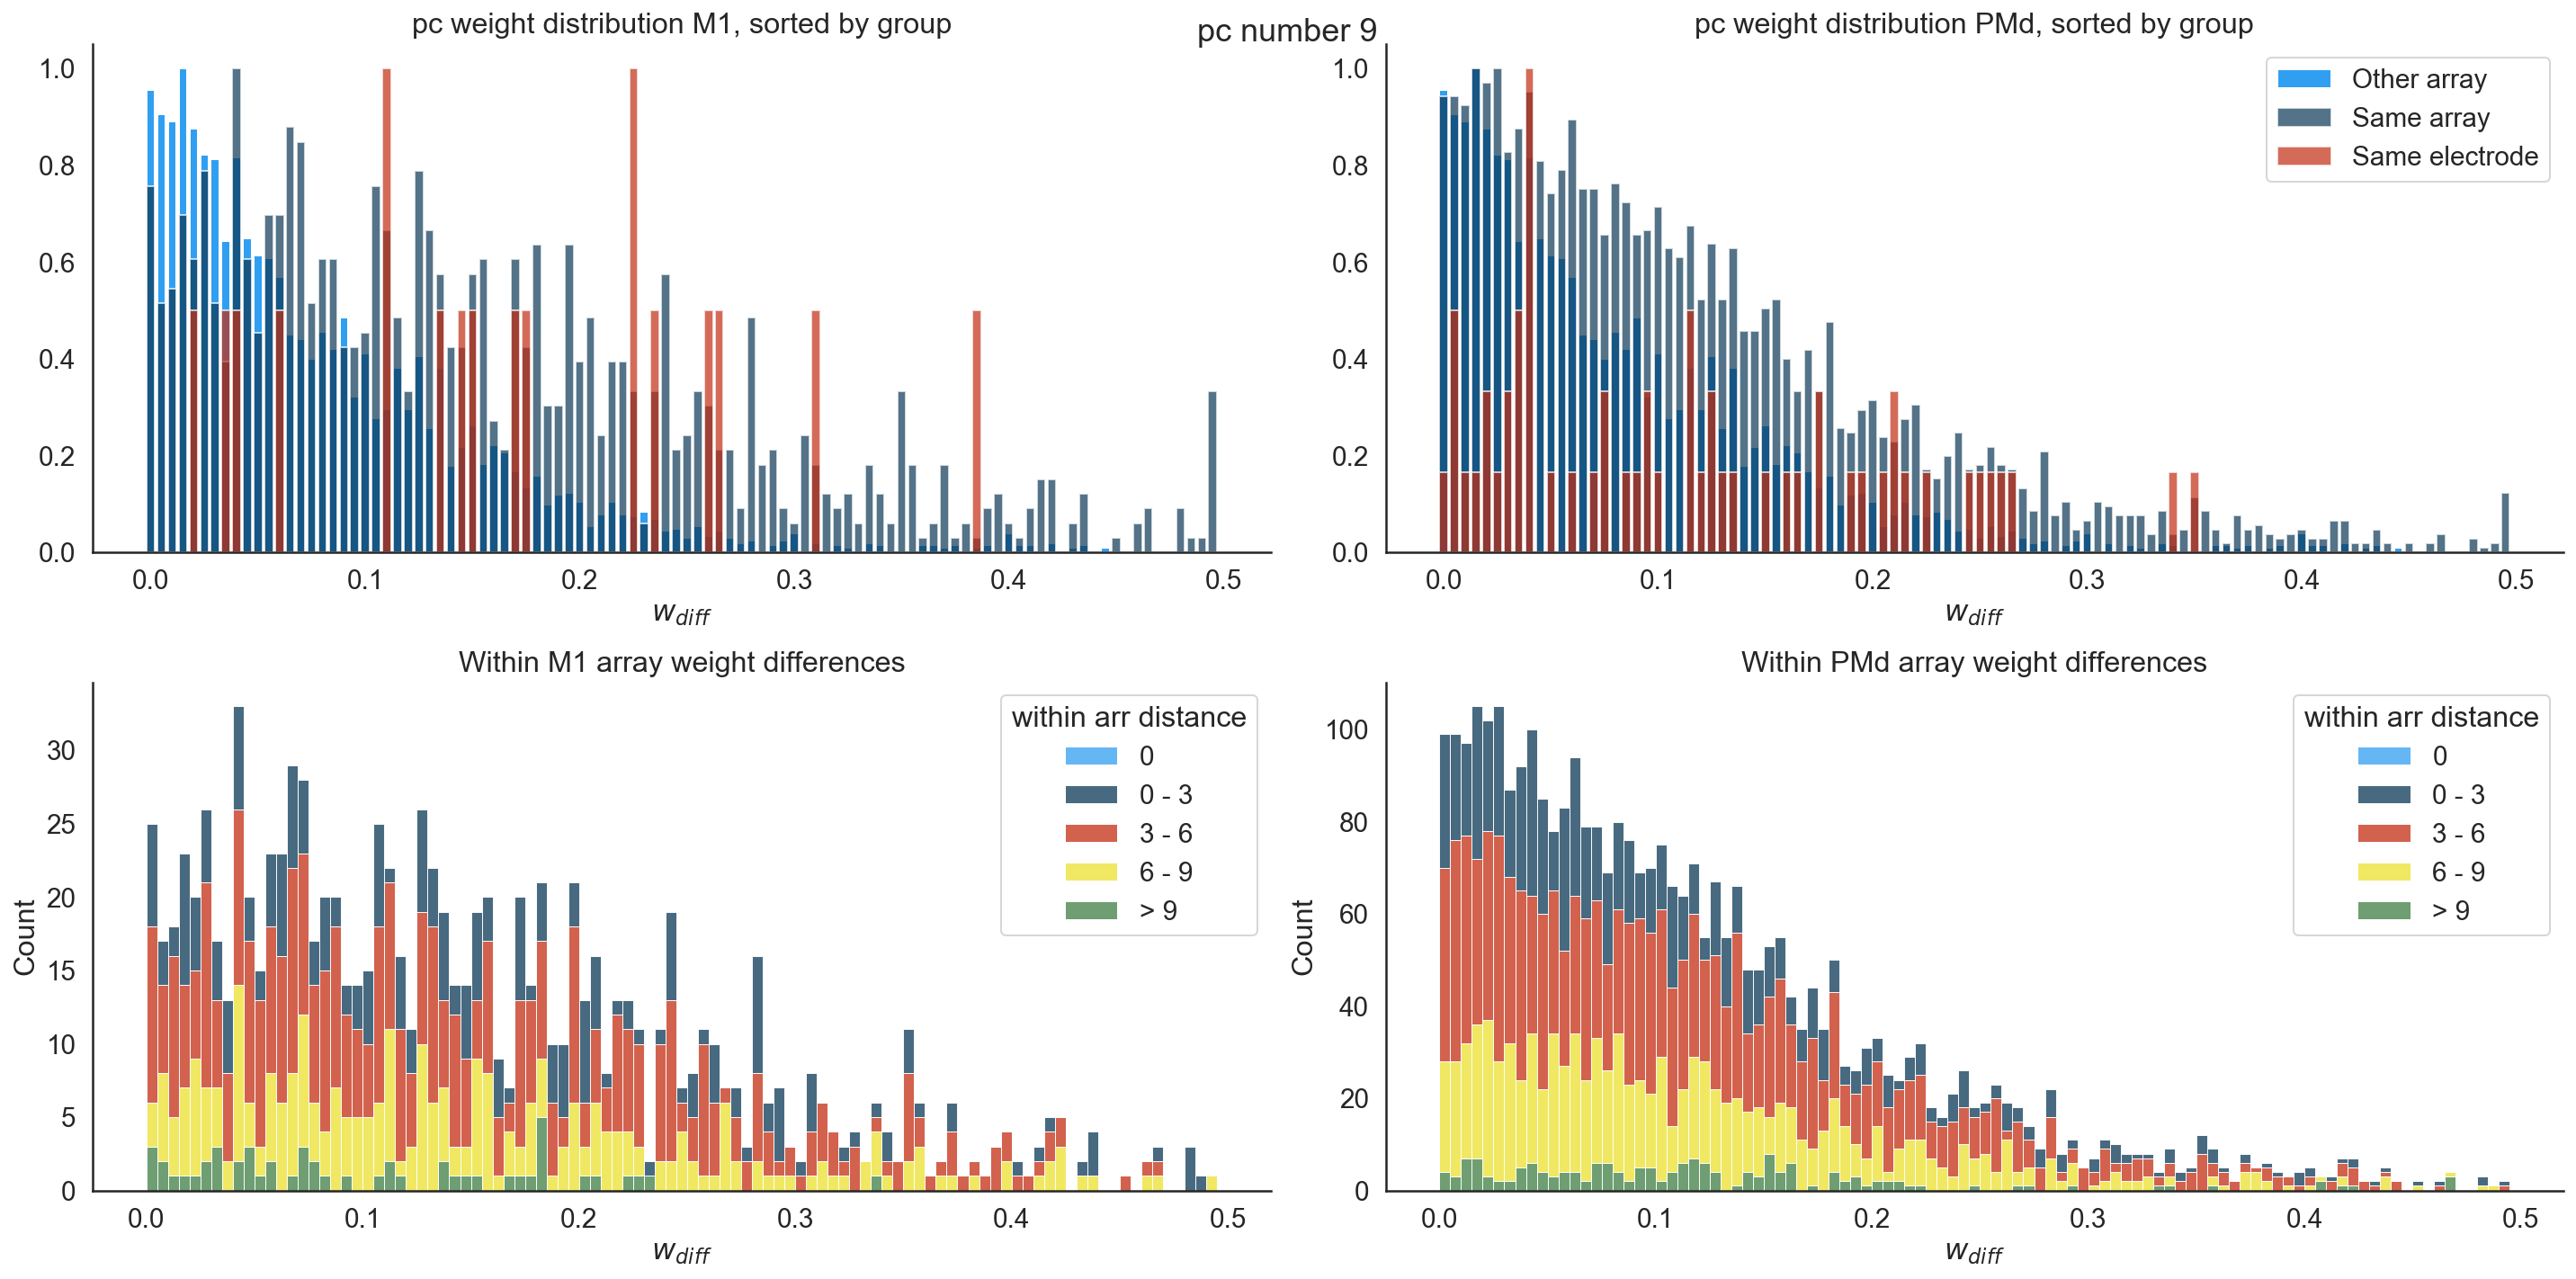

In [48]:
# for i in np.arange(0, 10, 2):
#     generate_weight_distrib(pc_num=i)

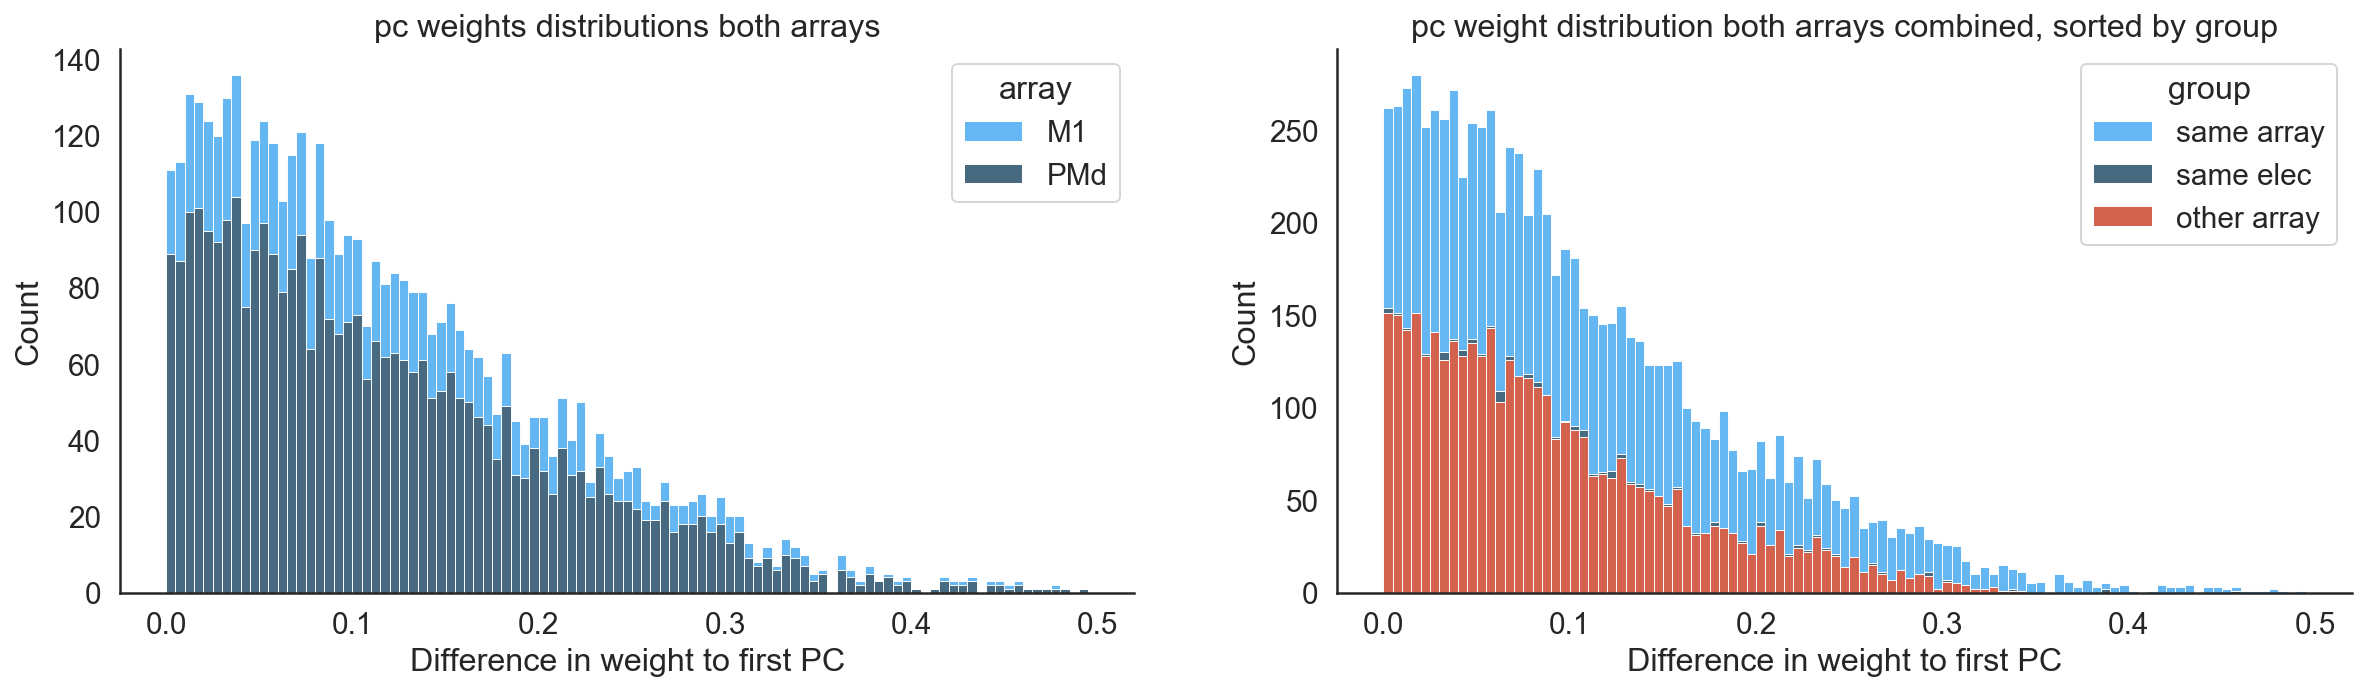

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(df, x='w_diff', hue='array', bins=binz, stat='count', multiple='stack', ax=ax1)
ax1.set_title('pc weights distributions both arrays')
ax1.set_xlabel('Difference in weight to first PC')
ax1.set_ylabel('Count')

sns.histplot(df, x='w_diff', hue='group', bins=binz, stat='count', multiple='stack', ax=ax2)
ax2.set_title('pc weight distribution both arrays combined, sorted by group')
ax2.set_xlabel('Difference in weight to first PC')
ax2.set_ylabel('Count')
sns.despine()

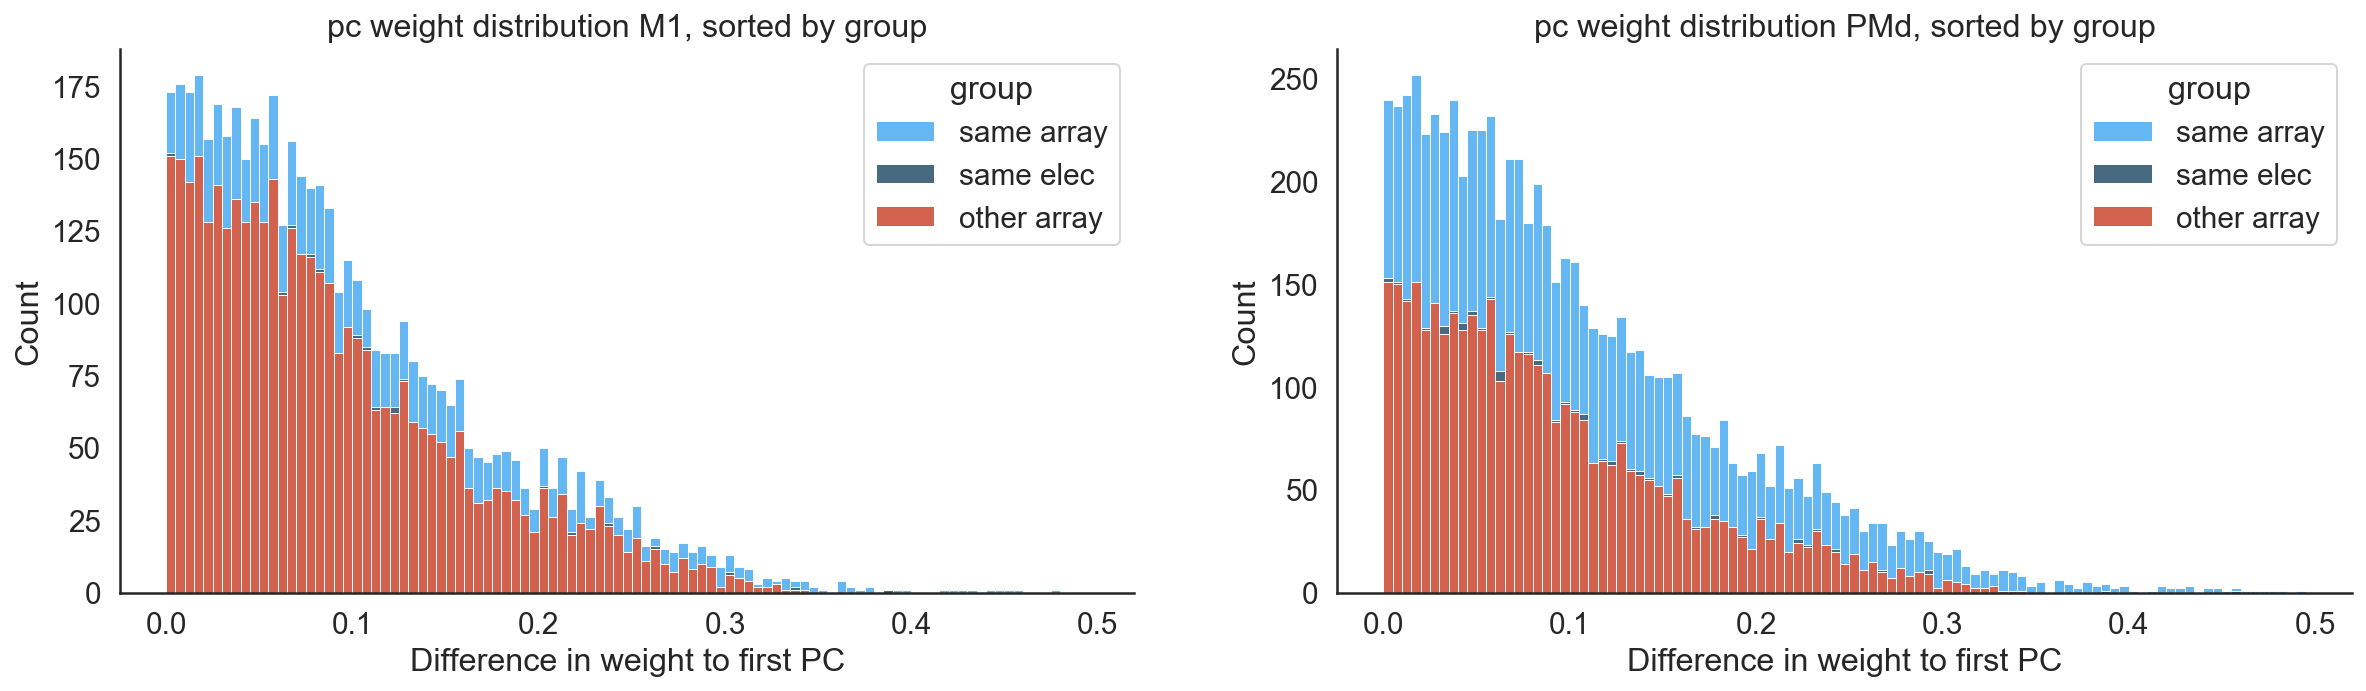

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(df_m1_other, x='w_diff', hue='group', bins=binz, stat='count', multiple='stack', ax=ax1)
ax1.set_title('pc weight distribution M1, sorted by group')
ax1.set_xlabel('Difference in weight to first PC')

sns.histplot(df_pmd_other, x='w_diff', hue='group', bins=binz, stat='count', multiple='stack', ax=ax2)
ax2.set_title('pc weight distribution PMd, sorted by group')
ax2.set_xlabel('Difference in weight to first PC')
sns.despine()

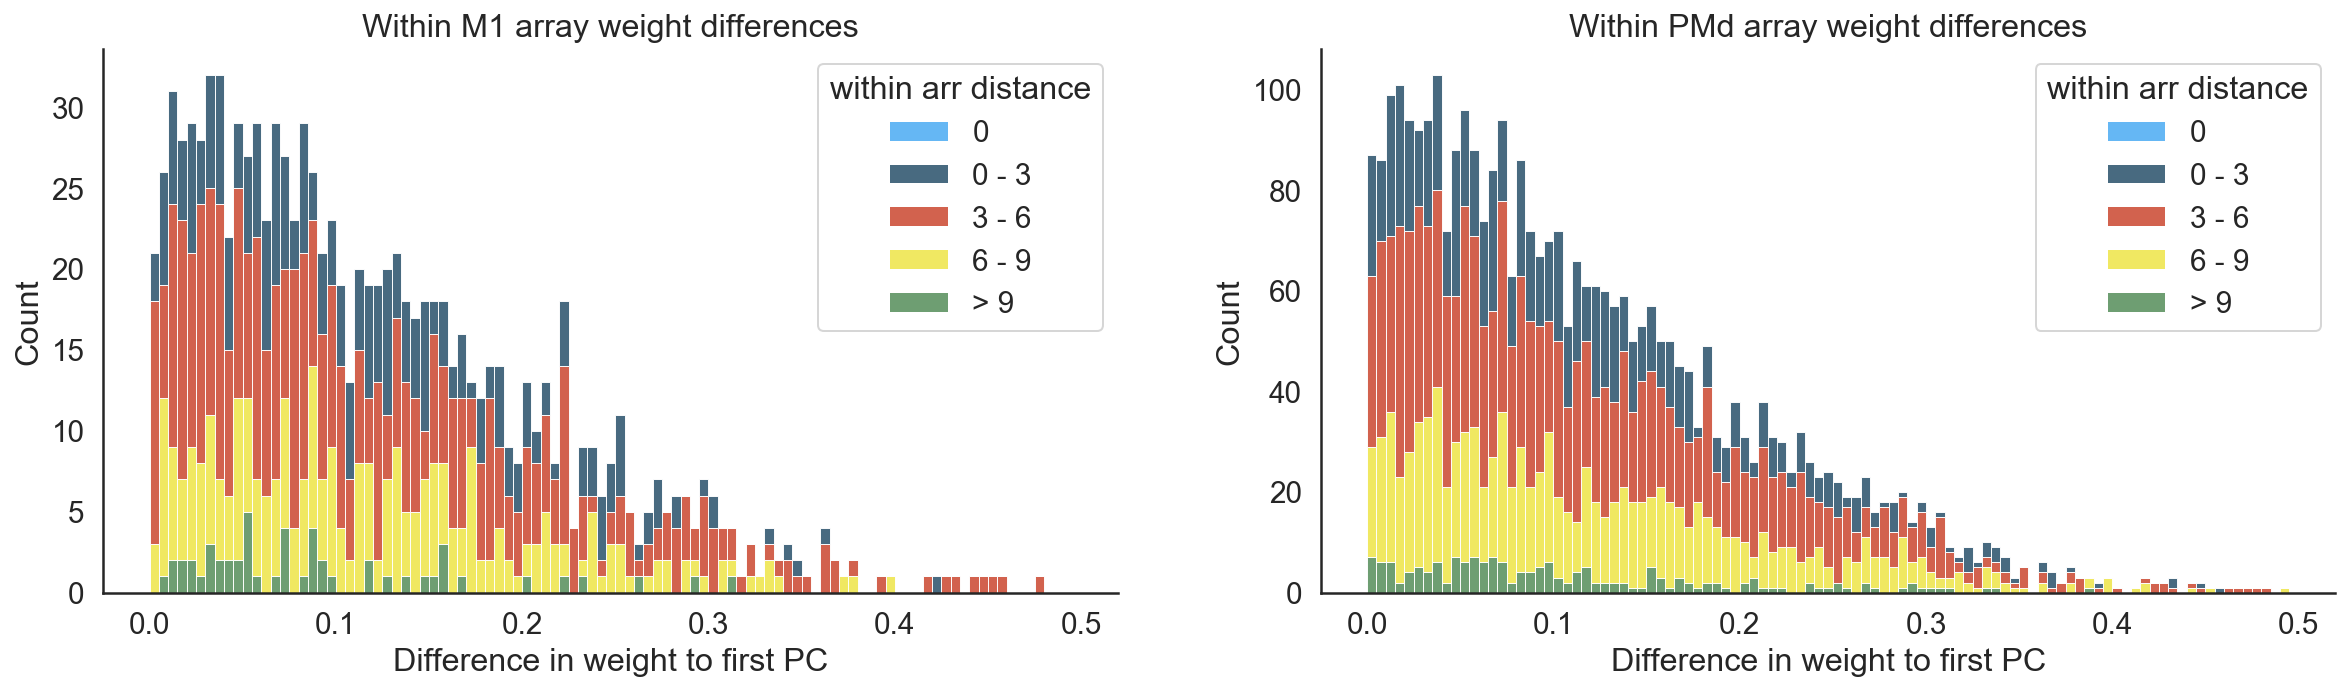

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(m1_cats, x='w_diff', hue='within arr distance', bins=binz, stat='count', ax=ax1, multiple='stack')
ax1.set_title('Within M1 array weight differences')
ax1.set_xlabel('Difference in weight to first PC')

sns.histplot(pmd_cats, x='w_diff', hue='within arr distance', bins=binz, stat='count', ax=ax2, multiple='stack')
ax2.set_title('Within PMd array weight differences')
ax2.set_xlabel('Difference in weight to first PC')
sns.despine()

### 3.5.A KS statistic on 2 samples PMd

In [52]:
df = df_pmd_other

same_elec = df.loc[df['group'] == 'same elec']['w_diff'].values
same_arr = df.loc[df['group'] == 'same array']['w_diff'].values
other_arr = df.loc[df['group'] == 'other array']['w_diff'].values

p_se_sa, _ = ks_2samp(same_elec, same_arr, alternative='greater', mode='auto')
p_se_oa, _ = ks_2samp(same_elec, other_arr, alternative='greater', mode='auto')
p_sa_oa, _ = ks_2samp(same_arr, other_arr, alternative='greater', mode='auto')

print(f'Same electrode to same array: P = {p_se_sa} \n')
print(f'Same electrode to other array: P = {p_se_oa} \n')
print(f'Same array to other array: P = {p_sa_oa} \n')

Same electrode to same array: P = 0.04314656935225092 

Same electrode to other array: P = 0.014580157134697807 

Same array to other array: P = 4.2519788556369674e-05 



### 3.5.B KS statistic on 2 samples M1

In [53]:
df = df_m1_other

same_elec = df.loc[df['group'] == 'same elec']['w_diff'].values
same_arr = df.loc[df['group'] == 'same array']['w_diff'].values
other_arr = df.loc[df['group'] == 'other array']['w_diff'].values

p_se_sa, _ = ks_2samp(same_elec, same_arr, alternative='greater', mode='asymp')
p_se_oa, _ = ks_2samp(same_elec, other_arr, alternative='greater', mode='asymp')
p_sa_oa, _ = ks_2samp(same_arr, other_arr, alternative='greater', mode='asymp')

print(f'Same electrode to same array: P = {p_se_sa} \n')
print(f'Same electrode to other array: P = {p_se_oa} \n')
print(f'Same array to other array: P = {p_sa_oa} \n')

Same electrode to same array: P = 0.051792620466185844 

Same electrode to other array: P = 0.03709874960836253 

Same array to other array: P = 0.0 



Scaling the plots (also in function: generate weight distrib)

In [57]:
# binz = np.arange(0, 0.5, 0.005)

# se = df.loc[df['group'] == 'same elec']['w_diff'].values
# sa = df.loc[df['group'] == 'same array']['w_diff'].values
# oa = df.loc[df['group'] == 'other array']['w_diff'].values

# fig, ax = plt.subplots(1, figsize=(12, 6))

# xbar = [str(bin) for bin in binz]
# intvals = np.append(binz, np.inf)

# ax.set_title('pc weight distribution M1, sorted by group')
# oa_bins = [np.sum((oa >= intvals[i]) & (oa < intvals[i + 1])) for i in range(len(binz))]
# oa_bins = oa_bins / max(oa_bins)
# ax.bar(x=xbar, height=oa_bins,  width=1.2, label='Other array')

# sa_bins = [np.sum((sa >= intvals[i]) & (sa < intvals[i + 1])) for i in range(len(binz))]
# sa_bins = sa_bins / max(sa_bins)
# ax.bar(x=xbar, height=sa_bins,  width=1.2, label='Same array', alpha=.8)

# se_bins = [np.sum((se >= intvals[i]) & (se < intvals[i + 1])) for i in range(len(binz))]
# se_bins = se_bins / max(se_bins)
# ax.bar(x=xbar, height=se_bins,  width=1.2, label='Same electrode', alpha=.8)
# ax.set_xlabel('Difference in weight')
# ax.set_xticks([str(i / 10) for i in range(0, 6)])
# ax.legend()
# sns.despine()

## 4. Compare weights on self-manifold with global-manifold

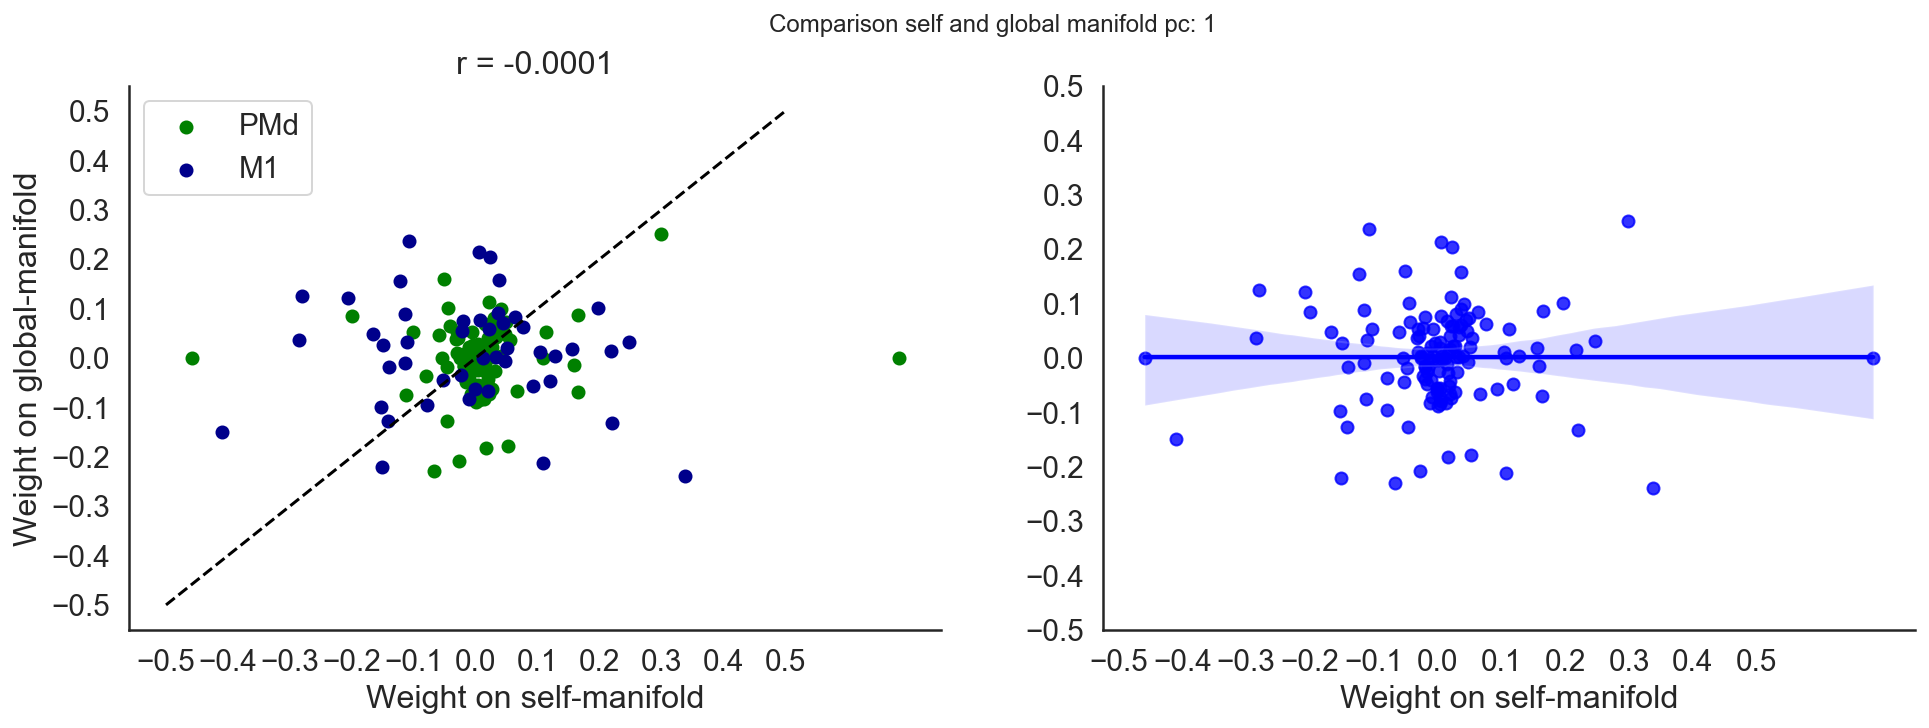

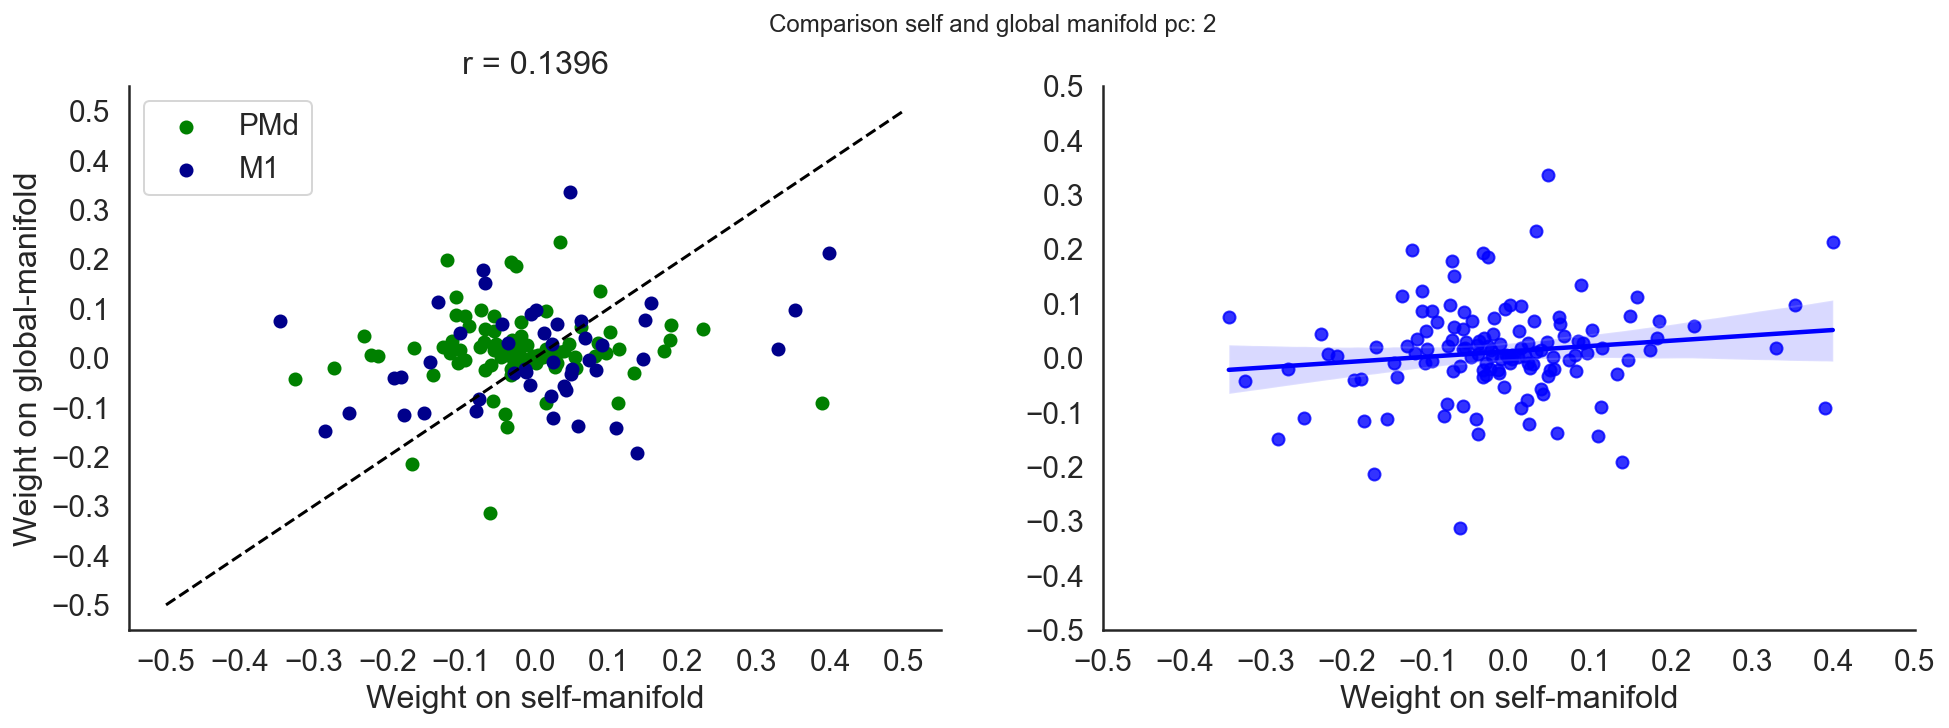

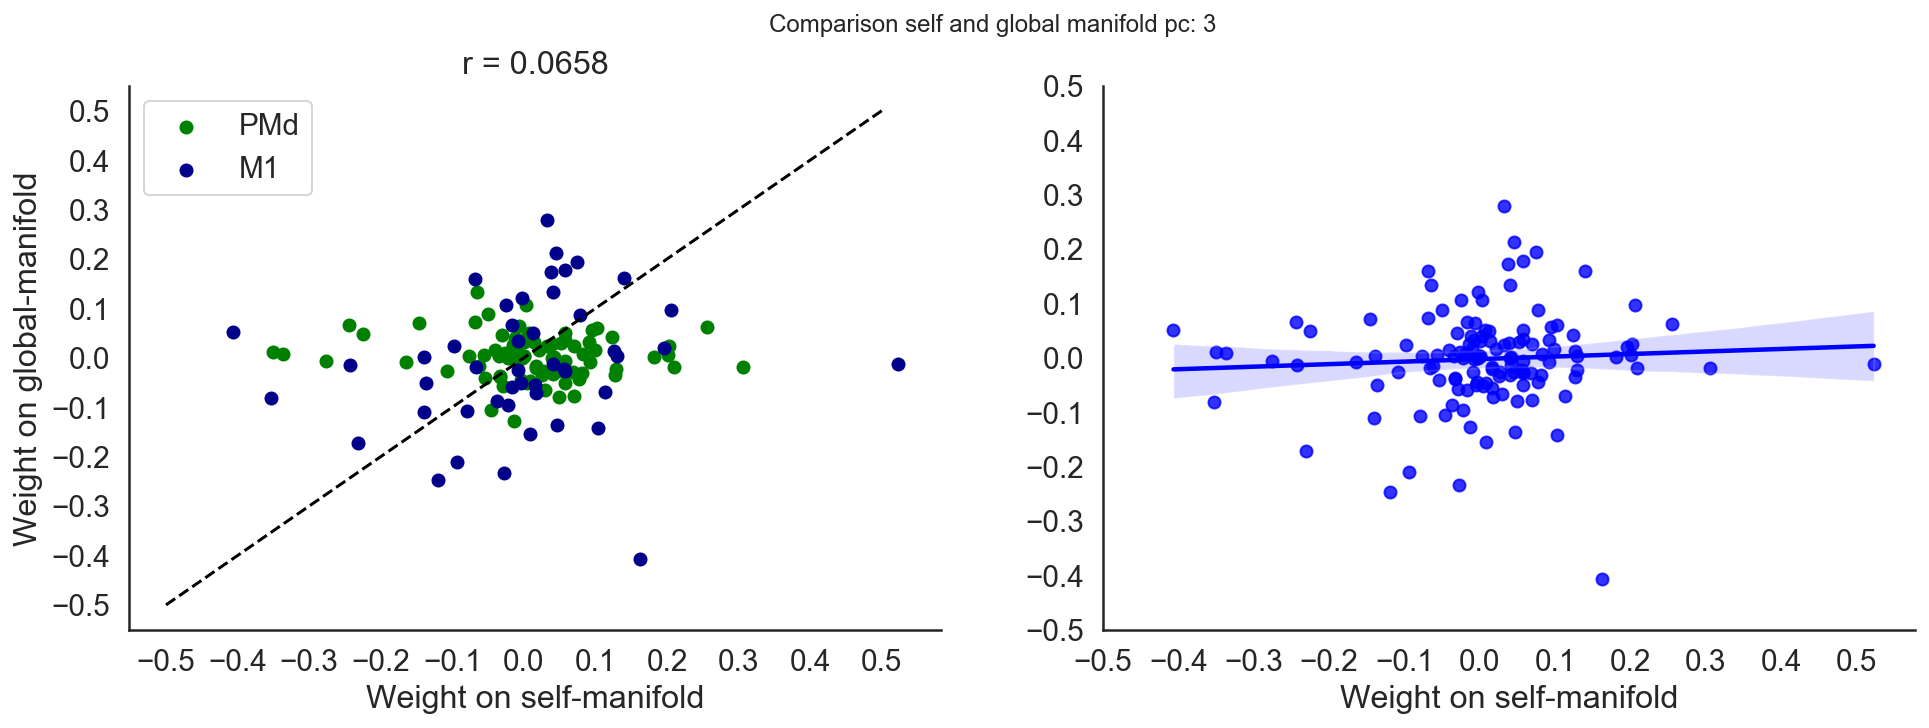

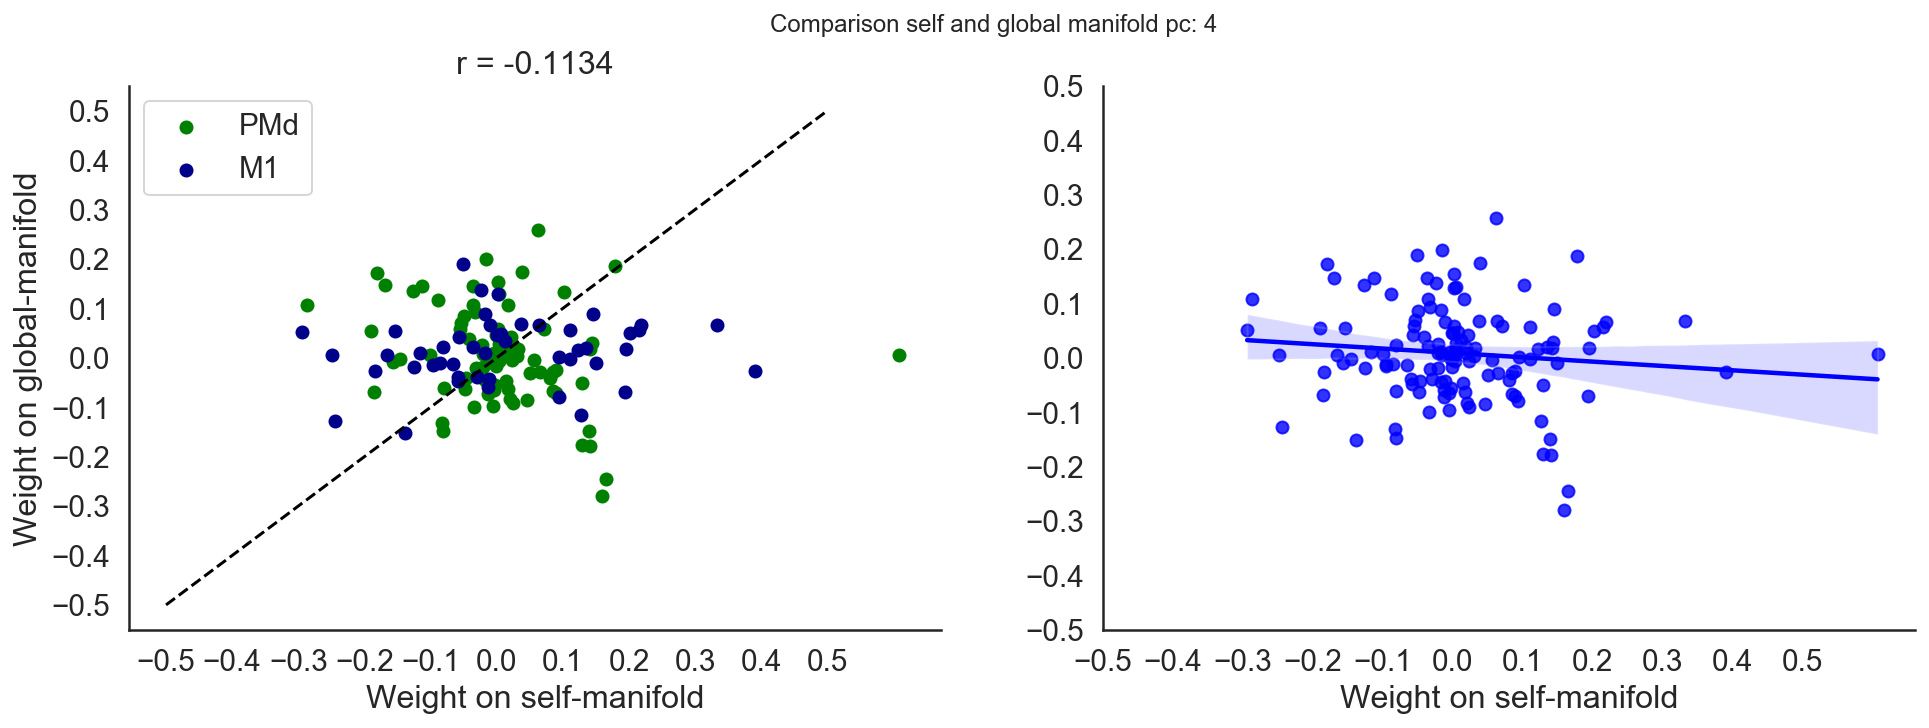

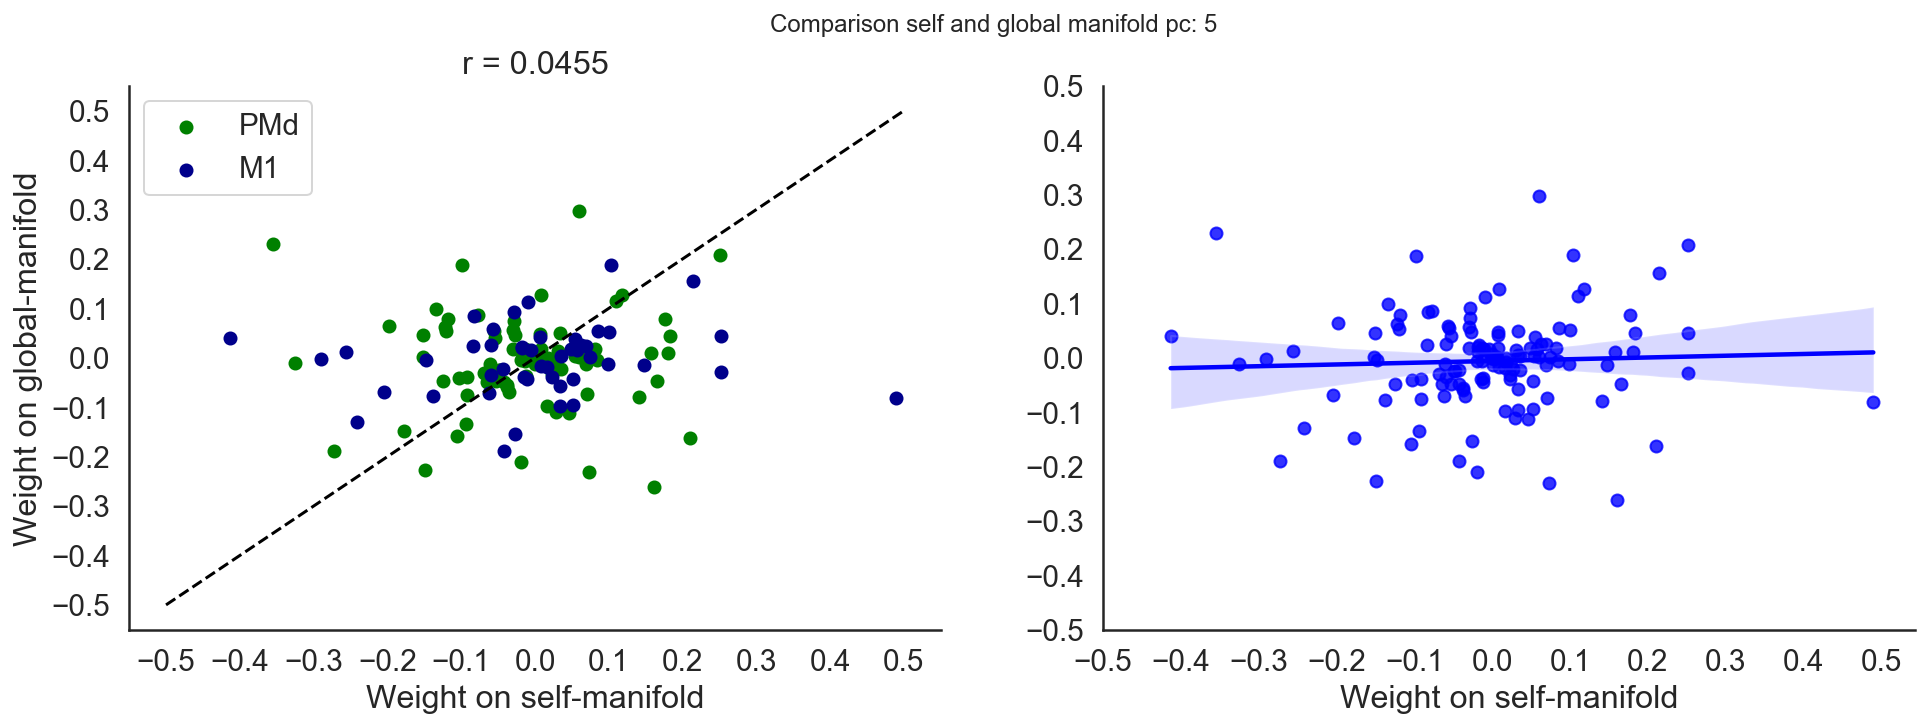

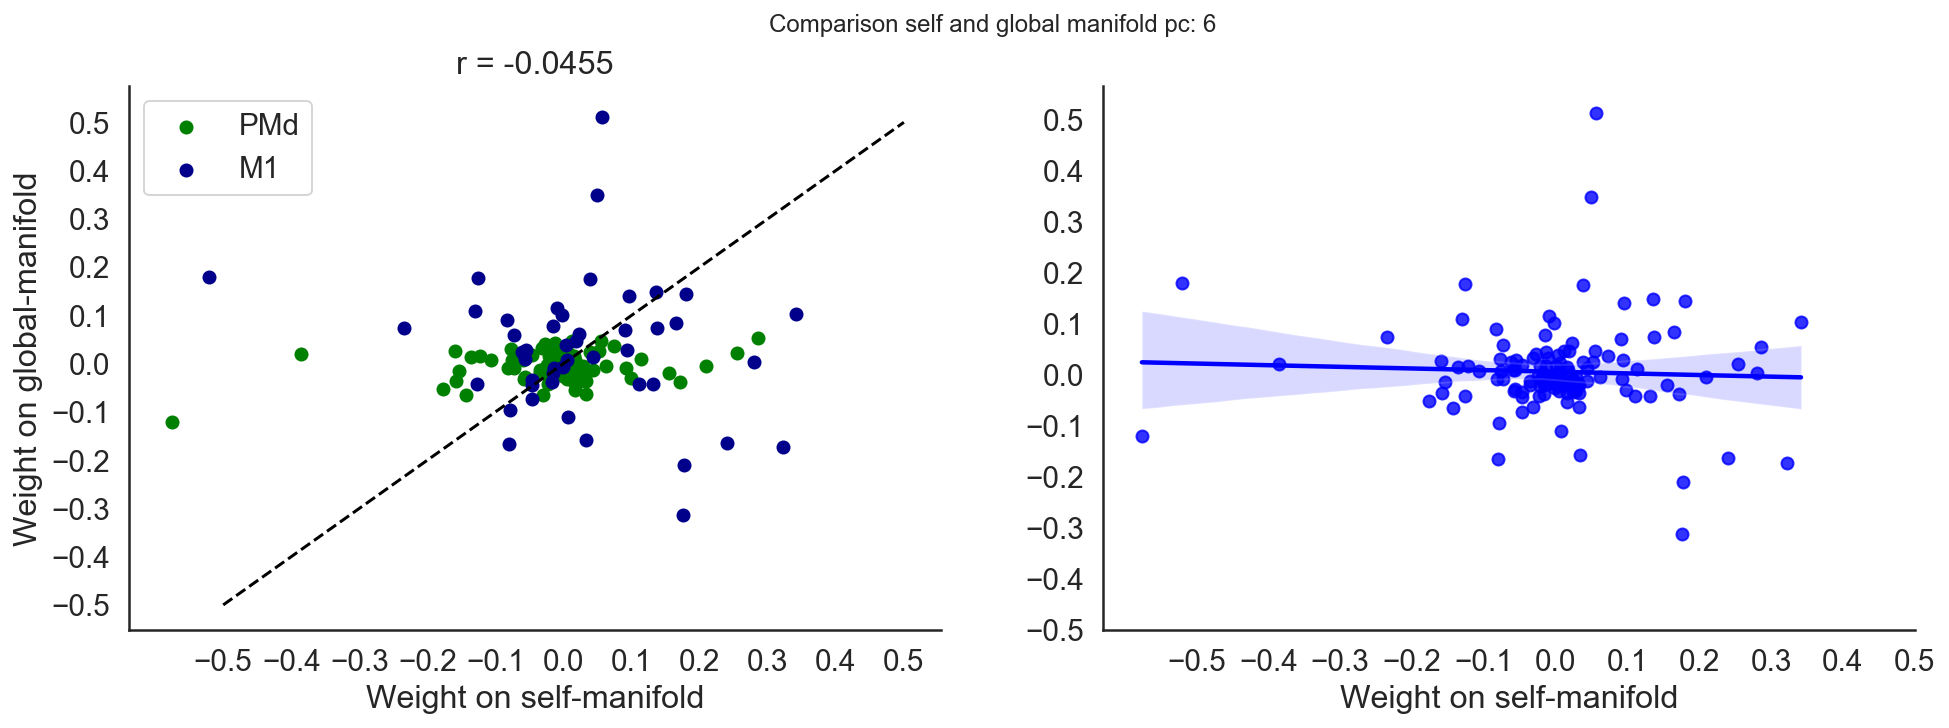

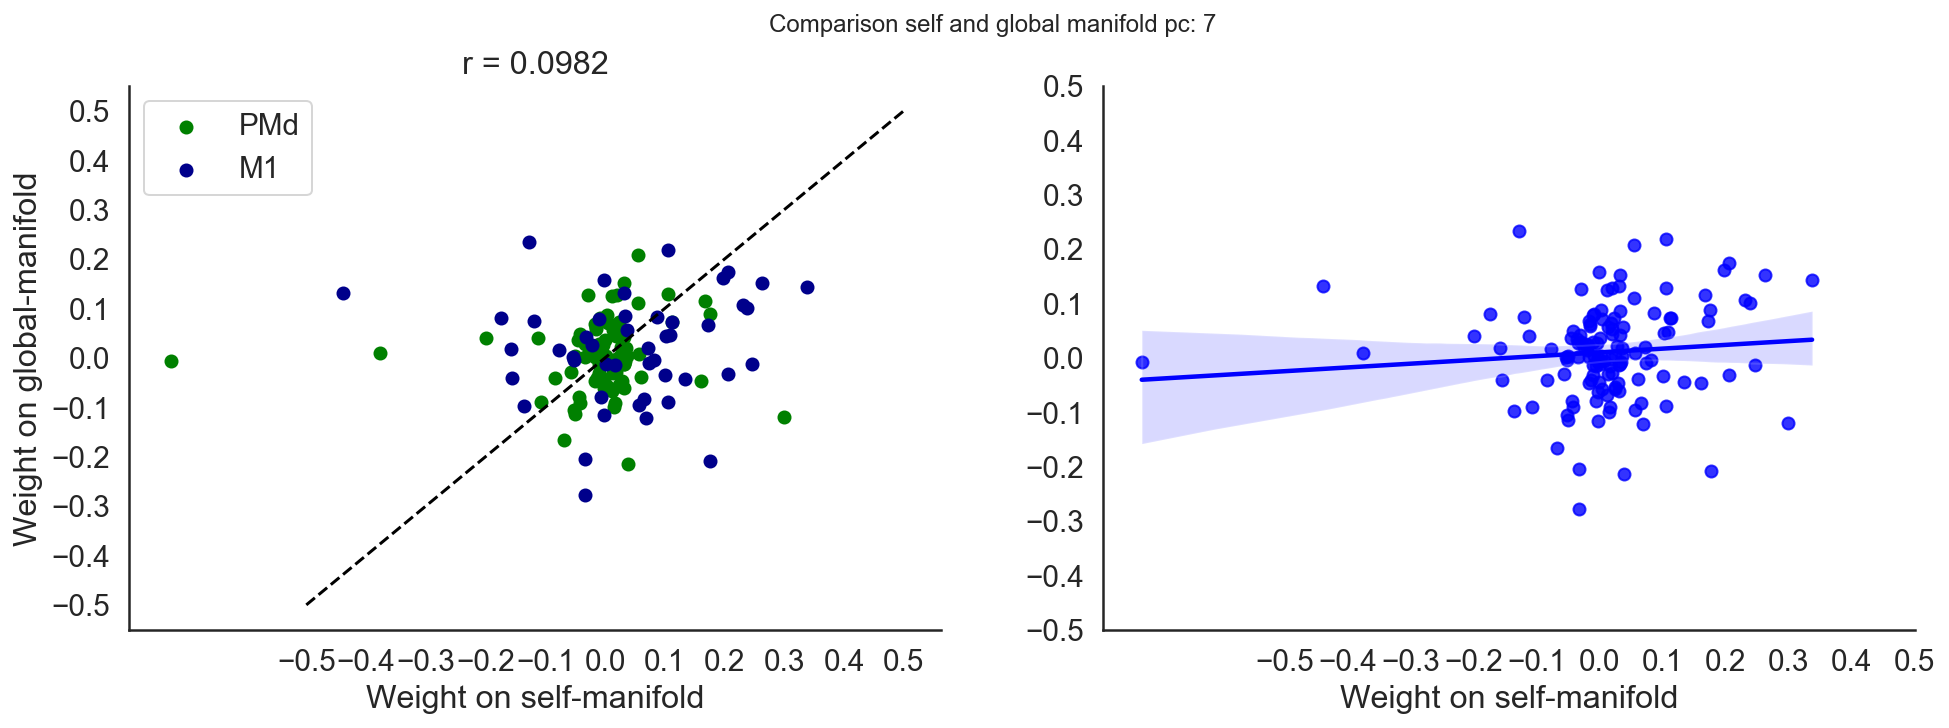

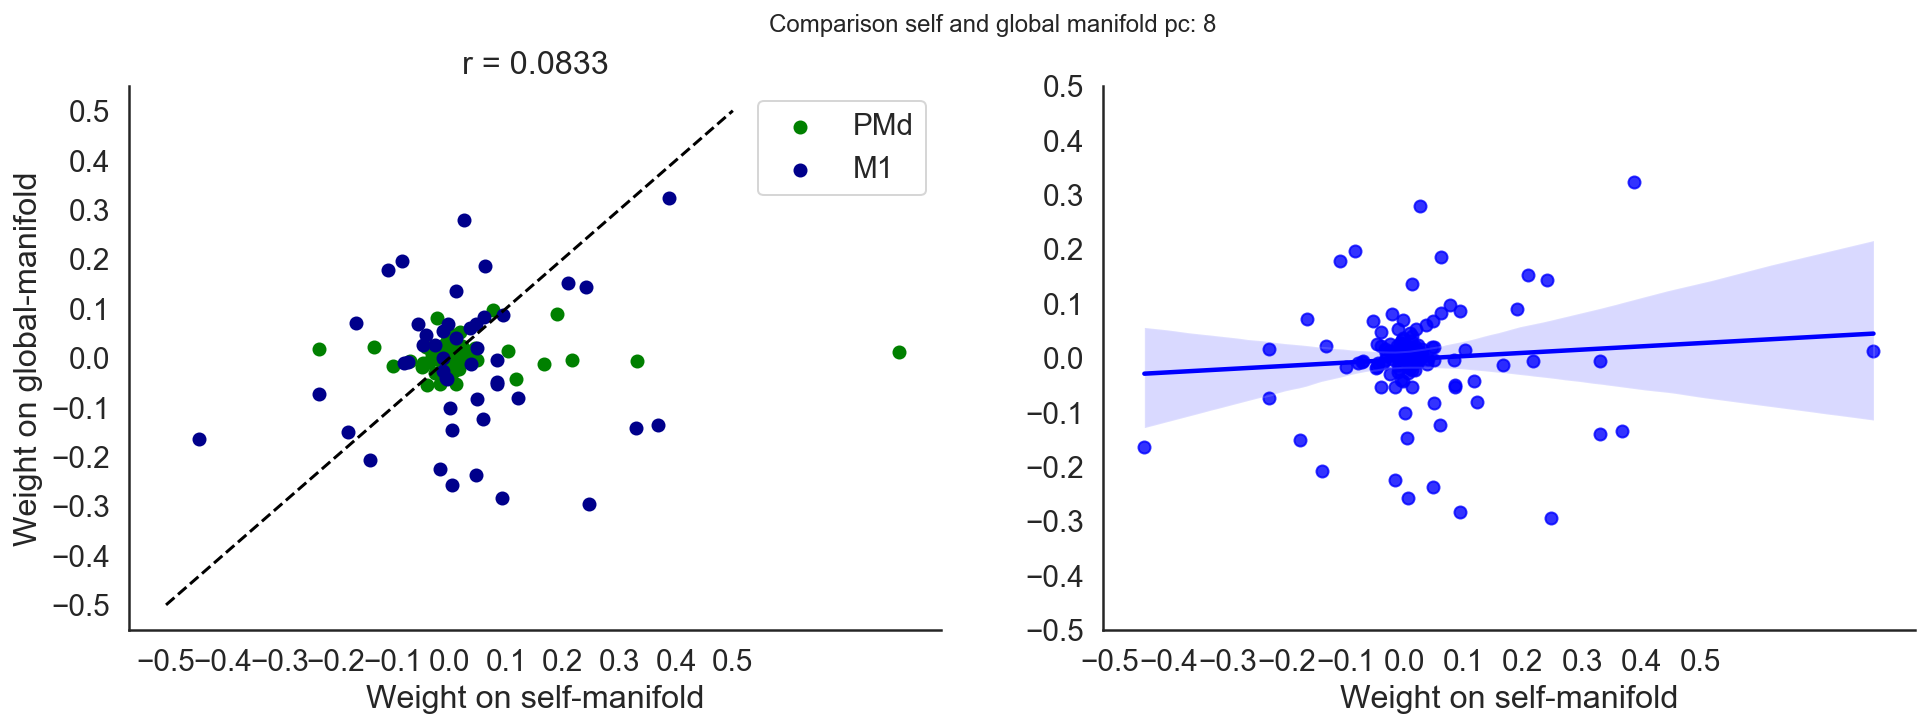

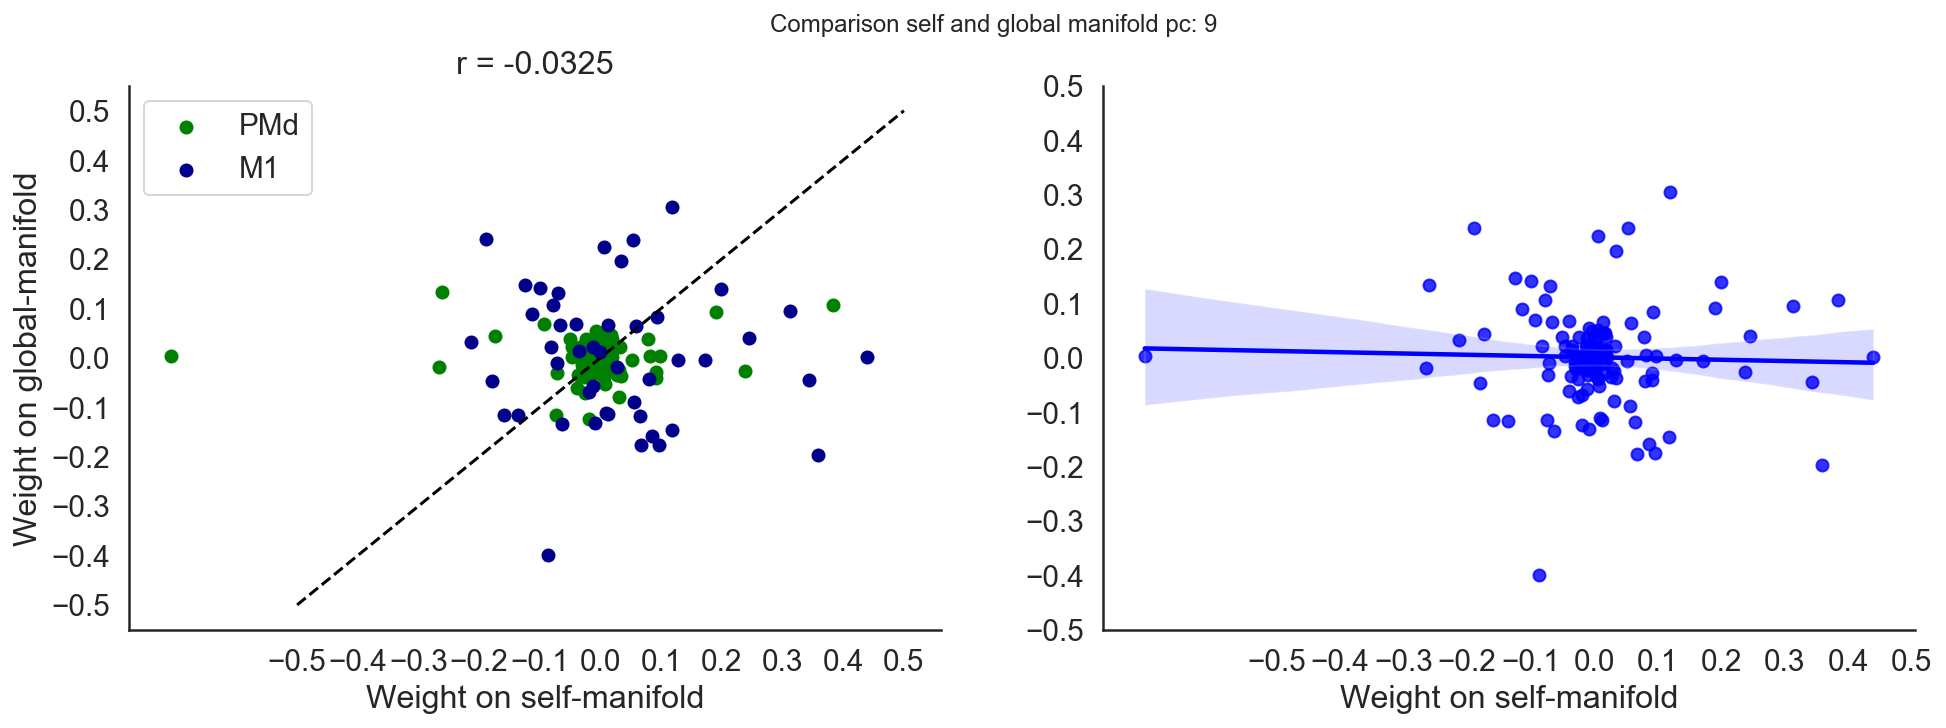

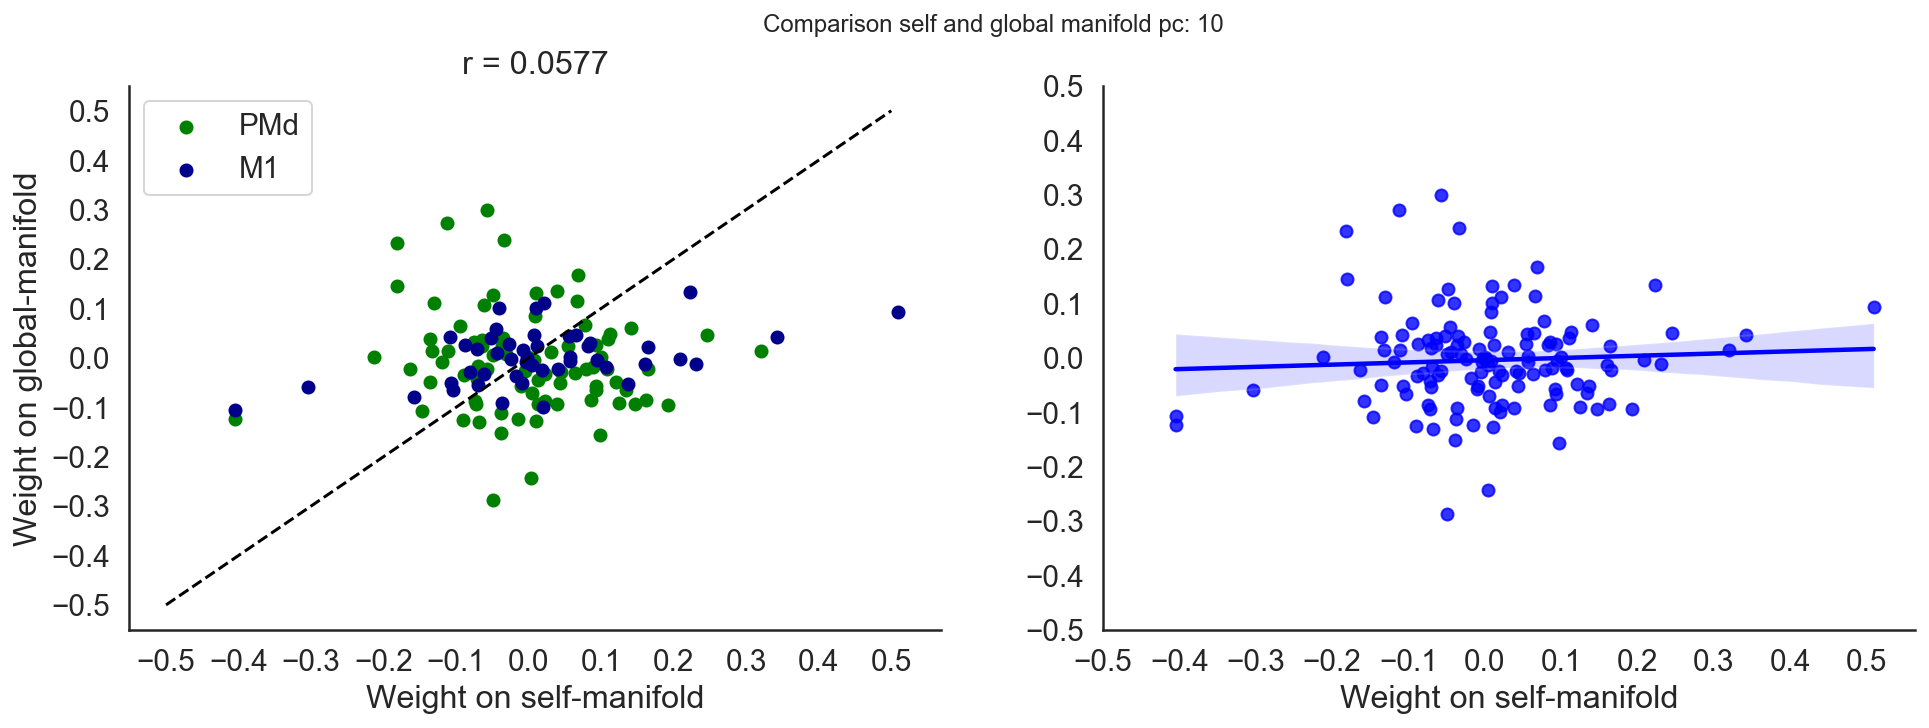

In [58]:
correlations = []

for k in np.arange(0, 10):
    
    w1 = np.array([pmd_pcs[:, k]])
    w2 = np.array([m1pmd_pcs[td.M1_spikes[0].shape[1]:, k]])
    temp1 = np.vstack((w1, w2))

    w1 = np.array([m1_pcs[:, k]])
    w2 = np.array([m1pmd_pcs[0:td.M1_spikes[0].shape[1], k]])
    temp2 = np.vstack((w1, w2))

    temp = np.hstack((temp1, temp2)).T
    r = np.corrcoef(temp[:, 0],temp[:, 1])[0, 1]
    correlations.append(r)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle(f'Comparison self and global manifold pc: {k+1}')

    ax1.set_title(f'r = {round(r,4)}')
    ax1.plot([-0.5, 0.5],[-0.5, 0.5],'k--')
    ax1.scatter(temp1[0, :], temp1[1, :], label='PMd', color='g')
    ax1.scatter(temp2[0, :], temp2[1, :], label='M1', color='darkblue')
    ax1.set_xlabel('Weight on self-manifold')
    ax1.set_ylabel('Weight on global-manifold')
    ax1.set_xticks(np.arange(-0.5, 0.6, 0.1))
    ax1.set_yticks(np.arange(-0.5, 0.6, 0.1))
    ax1.legend()

    sns.regplot(temp[:, 0], temp[:, 1], color='b', ax=ax2)
    ax2.set_xticks(np.arange(-0.5, 0.6, 0.1))
    ax2.set_yticks(np.arange(-0.5, 0.6, 0.1))
    ax2.set_xlabel('Weight on self-manifold')
    sns.despine()
    plt.show()

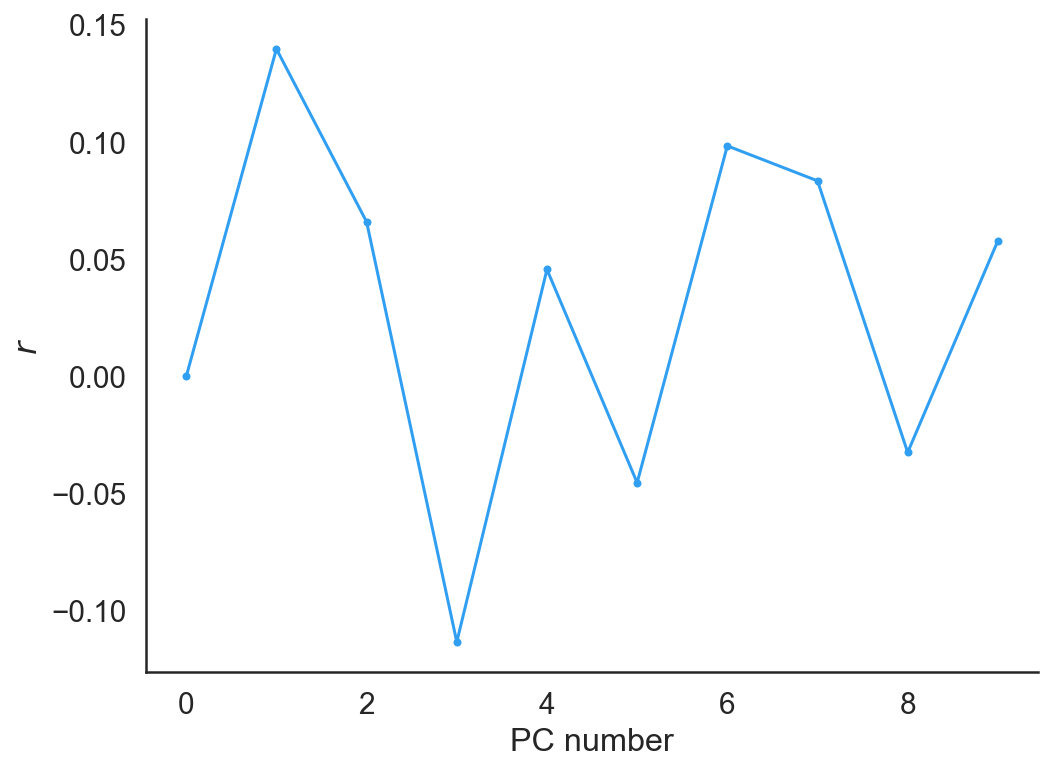

In [59]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.plot(correlations, '.-')
ax.set_xlabel('PC number')
ax.set_ylabel(r'$r$')
sns.despine()

The code below does the same but slightly different to check if what I was doing was correct, just leaving this here.

In [60]:
# # specify the principal component number 
# K = 0

# # # take abs value of the weights
# # m1_loadings = m1_loadings
# # pmd_loadings = pmd_loadings
# # m1pmd_loadings = m1pmd_loadings

# # take the first principal component self-manifold m1
# m1_self  = np.array([m1_loadings[:, K]])
# # take the first x elements that belong to global-manifold m1
# m1_glob = np.array([m1pmd_loadings[0:td.M1_spikes[0].shape[1], K]])

# # take the first principal component self-manifold pmd
# pmd_self  = np.array([pmd_loadings[:, K]])
# # take the last x elements that belong to global-manifold pmd
# pmd_glob = np.array([m1pmd_loadings[td.M1_spikes[0].shape[1]:, K]])

# # stack weights on self - global
# v_self = np.hstack((m1_self, pmd_self))
# v_glob = np.hstack((m1_glob, pmd_glob))

# # compute correlation between vectors
# r = np.corrcoef(v_self, v_glob)